# Conversion of leads with decision trees

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import data, Wiew  of 5 fist lines of df
df = pd.read_csv('EON.csv')
df.head()

Prospect ID  Lead Number              Lead Origin  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737                      API   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728                      API   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727  Landing Page Submission   
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719  Landing Page Submission   
4  3256f628-e534-4826-9d63-4a8b88782852       660681  Landing Page Submission   

      Lead Source Do Not Email Do Not Call  Converted  TotalVisits  \
0      Olark Chat           No          No          0          0.0   
1  Organic Search           No          No          0          5.0   
2  Direct Traffic           No          No          1          2.0   
3  Direct Traffic           No          No          0          1.0   
4          Google           No          No          1          2.0   

   Total Time Spent on Website  Page Views Per Visit  ...  \
0                            0                   0.0  ...   
1                          674                   2.5  ...   
2                         1532                   2.0  ...   
3                          305                   1.0  ...   
4                         1428                   1.0  ...   

  Get updates on DM Content    Lead Profile    City  \
0                        No          Select  Select   
1                        No          Select  Select   
2                        No  Potential Lead  Mumbai   
3                        No          Select  Mumbai   
4                        No          Select  Mumbai   

  Asymmetrique Activity Index Asymmetrique Profile Index  \
0                   02.Medium                  02.Medium   
1                   02.Medium                  02.Medium   
2                   02.Medium                    01.High   
3                   02.Medium                    01.High   
4                   02.Medium                    01.High   

  Asymmetrique Activity Score Asymmetrique Profile Score  \
0                        15.0                       15.0   
1                        15.0                       15.0   
2                        14.0                       20.0   
3                        13.0                       17.0   
4                        15.0                       18.0   

  I agree to pay the amount through cheque  \
0                                       No   
1                                       No   
2                                       No   
3                                       No   
4                                       No   

  A free copy of Mastering The Interview Last Notable Activity  
0                                     No              Modified  
1                                     No          Email Opened  
2                                    Yes          Email Opened  
3                                     No              Modified  
4                                     No              Modified  

[5 rows x 37 columns]

In [3]:
# We have two variables that could function as 'ID' Let's drop the more complex one, Prospect ID.
df.drop(columns= 'Prospect ID', axis = 1, inplace = True)
df.set_index('Lead Number', inplace = True)

In [4]:
# Let's examine the data to check its type and see if there are any missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9240 entries, 660737 to 579533
Data columns (total 35 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Lead Origin                                    9240 non-null   object 
 1   Lead Source                                    9204 non-null   object 
 2   Do Not Email                                   9240 non-null   object 
 3   Do Not Call                                    9240 non-null   object 
 4   Converted                                      9240 non-null   int64  
 5   TotalVisits                                    9103 non-null   float64
 6   Total Time Spent on Website                    9240 non-null   int64  
 7   Page Views Per Visit                           9103 non-null   float64
 8   Last Activity                                  9137 non-null   object 
 9   Country                                        677

<Axes: xlabel='count', ylabel='Lead Source'>

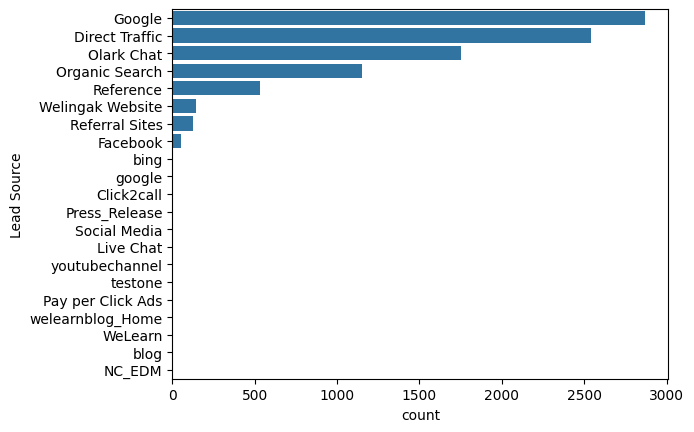

In [5]:
# Let's make a bar chart to count the sources of traffic
sns.countplot(y='Lead Source', data = df, order = df['Lead Source'].value_counts().index)

We have on our data missing values, we will simply assign the value "Desconocido" to the missing values.

In [6]:
df['Lead Source'] =df['Lead Source'].fillna('Desconocido')

Data Type Correction: Do Not Email, Do Not Call, Converted

Do Not Email: A binary indicator variable selected by the client where they choose whether or not they want to receive emails about the course.

Do Not Call: A binary indicator variable selected by the client where they choose whether or not they want to receive calls about the course.

Converted: The target variable. Indicates whether a lead has been successfully converted or not.









In [7]:
# Convert the variables to boolean. Since we will do the same with all three, let's use a for loop
for v in ['Do Not Email', 'Do Not Call', 'Converted']:
    df[v] = df[v].replace('Yes', 1)
    df[v] = df[v].replace('No', 0)
    df[v] = df[v].astype(bool)

Handling Missing Values: TotalVisits and Page Views Per Visit

TotalVisits: The total number of visits made by the client on the website.

Page Views Per Visit: The total number of pages viewed by the client during their visits on the website.

We evaluate the distribution of each of these features to determine the best method for imputation.

In [8]:
# Let's examine the distribution of Total Visits
df['TotalVisits'].describe()

count    9103.000000
mean        3.445238
std         4.854853
min         0.000000
25%         1.000000
50%         3.000000
75%         5.000000
max       251.000000
Name: TotalVisits, dtype: float64

<Axes: xlabel='TotalVisits', ylabel='Count'>

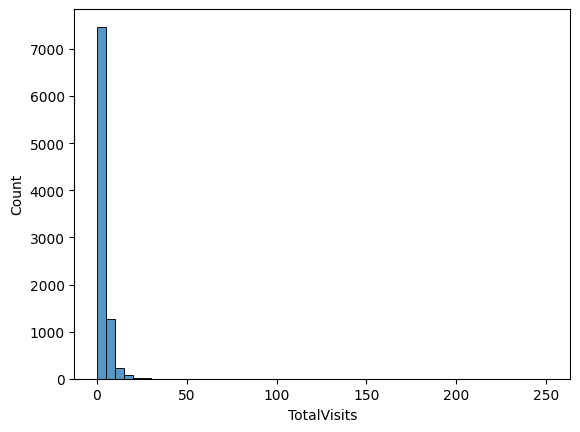

In [9]:
# Let's create a histogram of the distribution
sns.histplot(x='TotalVisits', data=df, bins=50)

In [10]:
# Let's examine the distribution of 'Page Views Per Visit'
df['Page Views Per Visit'].describe()

count    9103.000000
mean        2.362820
std         2.161418
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        55.000000
Name: Page Views Per Visit, dtype: float64

<Axes: xlabel='Page Views Per Visit', ylabel='Count'>

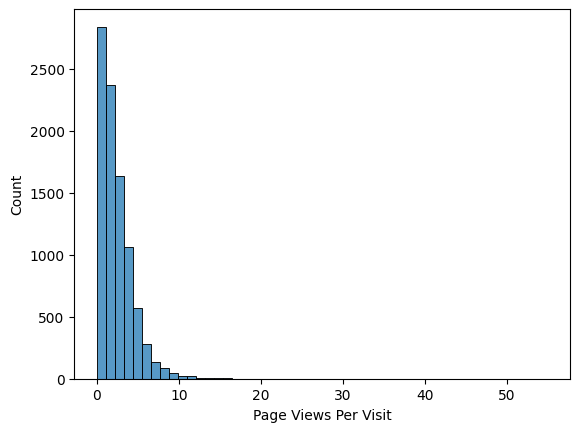

In [11]:
# Let's examine the distribution of 'Page Views Per Visit'
sns.histplot(x='Page Views Per Visit', data=df, bins=50)

We already have a distribution that is severely skewed, using the median for imputing missing values is appropriate because the median is less susceptible to the influence of outliers or extreme values, providing a better central estimate for skewed data.

In [12]:
# Impute the median for the missing values in TotalVisits
df['TotalVisits'] = df['TotalVisits'].fillna(df['TotalVisits'].median())
# Impute the median for the missing values in 'Page Views Per Visit'
df['Page Views Per Visit'] = df['Page Views Per Visit'].fillna(df['Page Views Per Visit'].median())
# Watch our changes
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9240 entries, 660737 to 579533
Data columns (total 35 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Lead Origin                                    9240 non-null   object 
 1   Lead Source                                    9240 non-null   object 
 2   Do Not Email                                   9240 non-null   bool   
 3   Do Not Call                                    9240 non-null   bool   
 4   Converted                                      9240 non-null   bool   
 5   TotalVisits                                    9240 non-null   float64
 6   Total Time Spent on Website                    9240 non-null   int64  
 7   Page Views Per Visit                           9240 non-null   float64
 8   Last Activity                                  9137 non-null   object 
 9   Country                                        677

<Axes: xlabel='count', ylabel='Last Activity'>

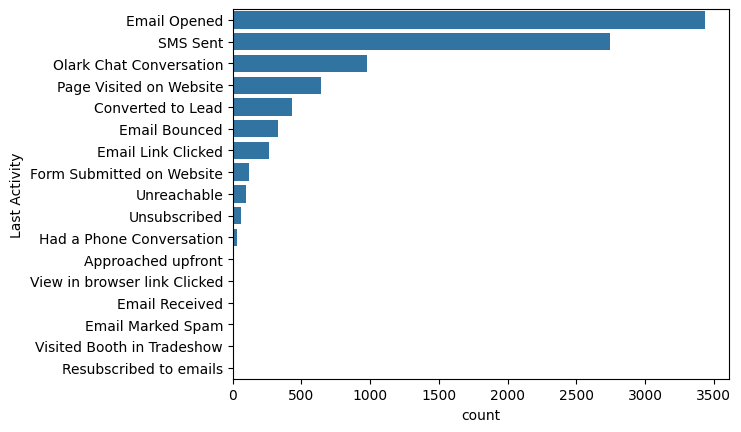

In [13]:
# Distribution Plot of Last Activity
sns.countplot(y='Last Activity', data = df, order = df['Last Activity'].value_counts().index)

In [14]:
df['Last Activity'] = df['Last Activity'].fillna('Desconocido')

<Axes: xlabel='count', ylabel='Country'>

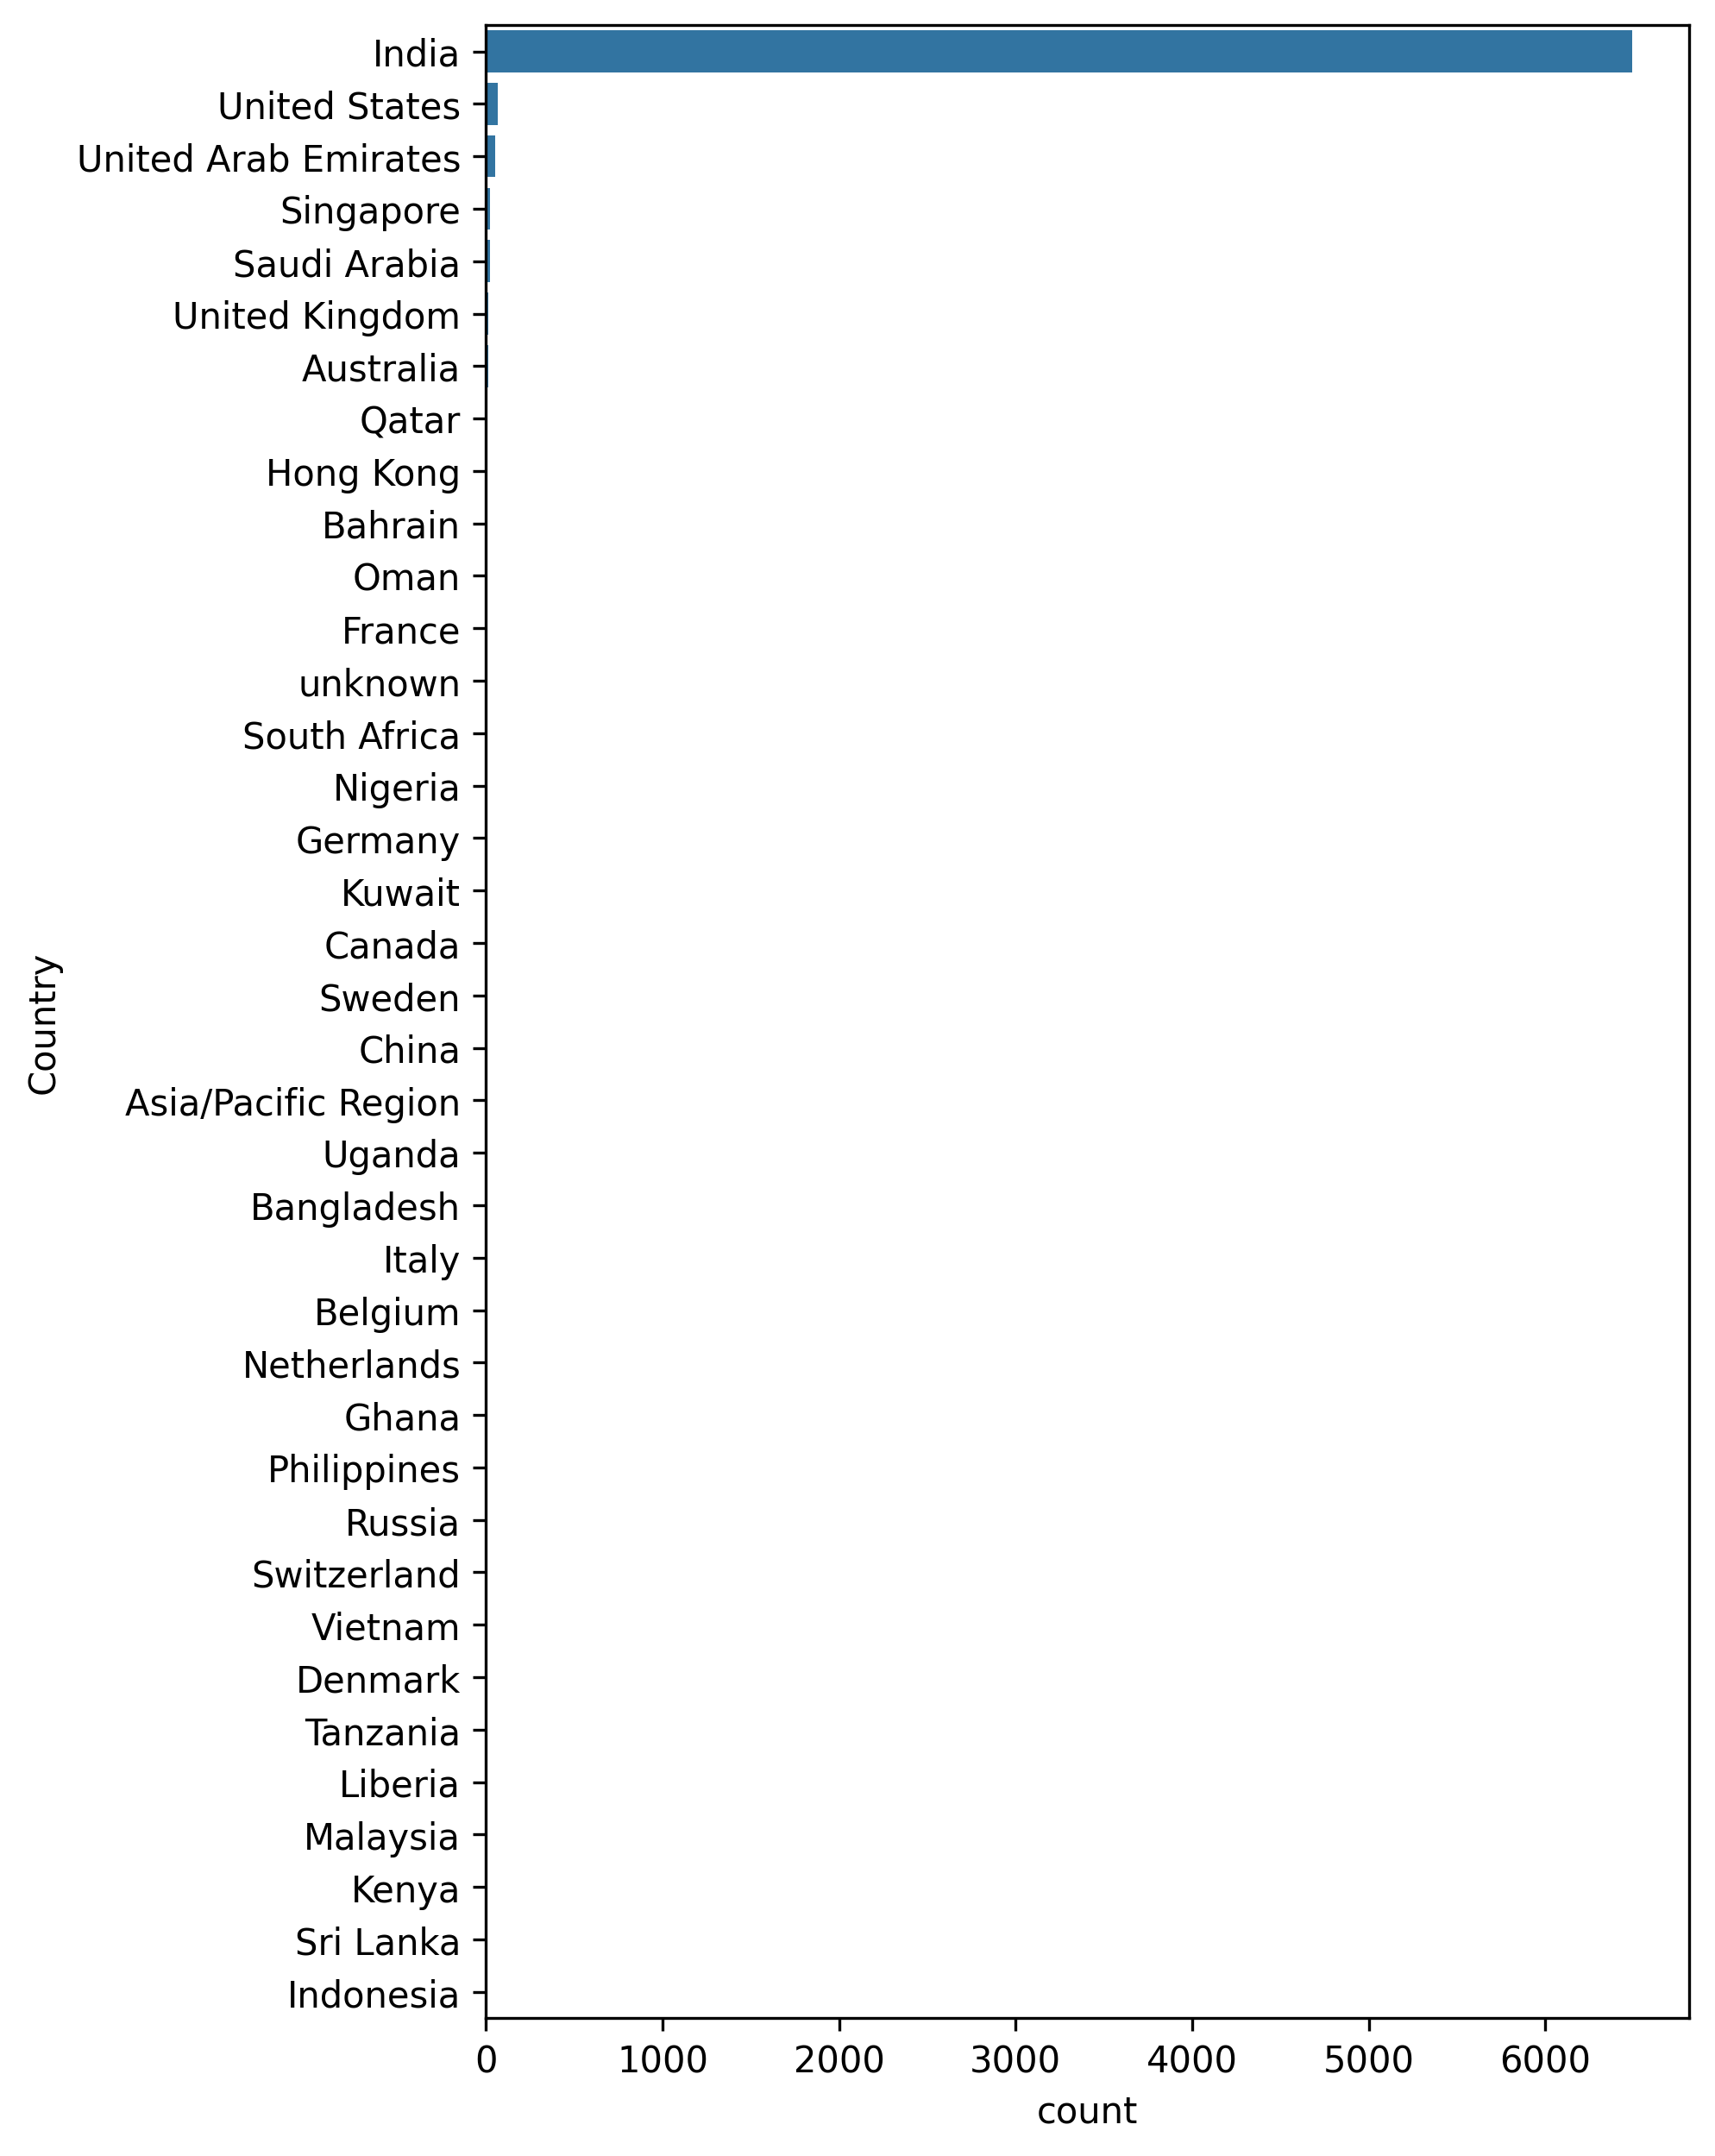

In [15]:
# Let's analyze Country: the lead's country
plt.figure(figsize = (6, 10), dpi = 300)
sns.countplot(y='Country', data = df, order = df['Country'].value_counts().index)

In [16]:
6779/9240

0.7336580086580087

The number of missing data is more than a quarter. And more than two-thirds are from India...
In this particular case, we wouldn’t want to simply place 'Descoconocido' when we know it is very likely
that they are from India and when we have another variable (City) 
that can help us deduce the country of the missing values

 Let's plot the distribution of 'City' when 'Country' is missing

<Axes: xlabel='count', ylabel='City'>

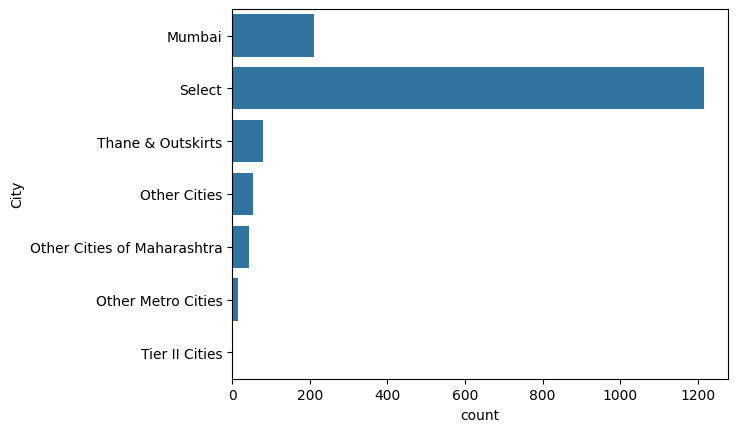

In [17]:
sns.countplot(y='City', data = df[df['Country'].isna()], order = df['City'].value_counts().index)

In [18]:
# Analyzing this variable provides us with very relevant insights for handling missing values in 'Country'
# We can assign 'India' to the missing values where the City is Mumbai, Other Cities of Maharashtra, or Thane & Outskirts
# We create a for loop with a nested if statement. For records in the list of the three cities in India,
# we assign India; for the rest of the missing values, we assign "Desconocido"

In [19]:
ciudades_india = ['Mumbai','Other Cities of Maharashtra','Thane & Outskirts']

for i in df[df['Country'].isnull()].index:
    if df.loc[i, 'City'] in ciudades_india:
        df.loc[i, 'Country'] = 'India'
    else:
        df.loc[i, 'Country'] = 'Desconocido'

In [20]:
# The variables are similar and have no missing values
# We will handle them similarly. Let's convert them to boolean values using a for loop

for c in ['Search', 'Magazine', 'Newspaper Article', 'X Education Forums', 'Newspaper', 
          'Digital Advertisement', 'Through Recommendations', 'Receive More Updates About Our Courses']:
    df[c] = df[c].replace('Yes', 1)
    df[c] = df[c].replace('No', 0)
    df[c] = df[c].astype(bool)

In [21]:
# Check our changes
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9240 entries, 660737 to 579533
Data columns (total 35 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Lead Origin                                    9240 non-null   object 
 1   Lead Source                                    9240 non-null   object 
 2   Do Not Email                                   9240 non-null   bool   
 3   Do Not Call                                    9240 non-null   bool   
 4   Converted                                      9240 non-null   bool   
 5   TotalVisits                                    9240 non-null   float64
 6   Total Time Spent on Website                    9240 non-null   int64  
 7   Page Views Per Visit                           9240 non-null   float64
 8   Last Activity                                  9240 non-null   object 
 9   Country                                        924

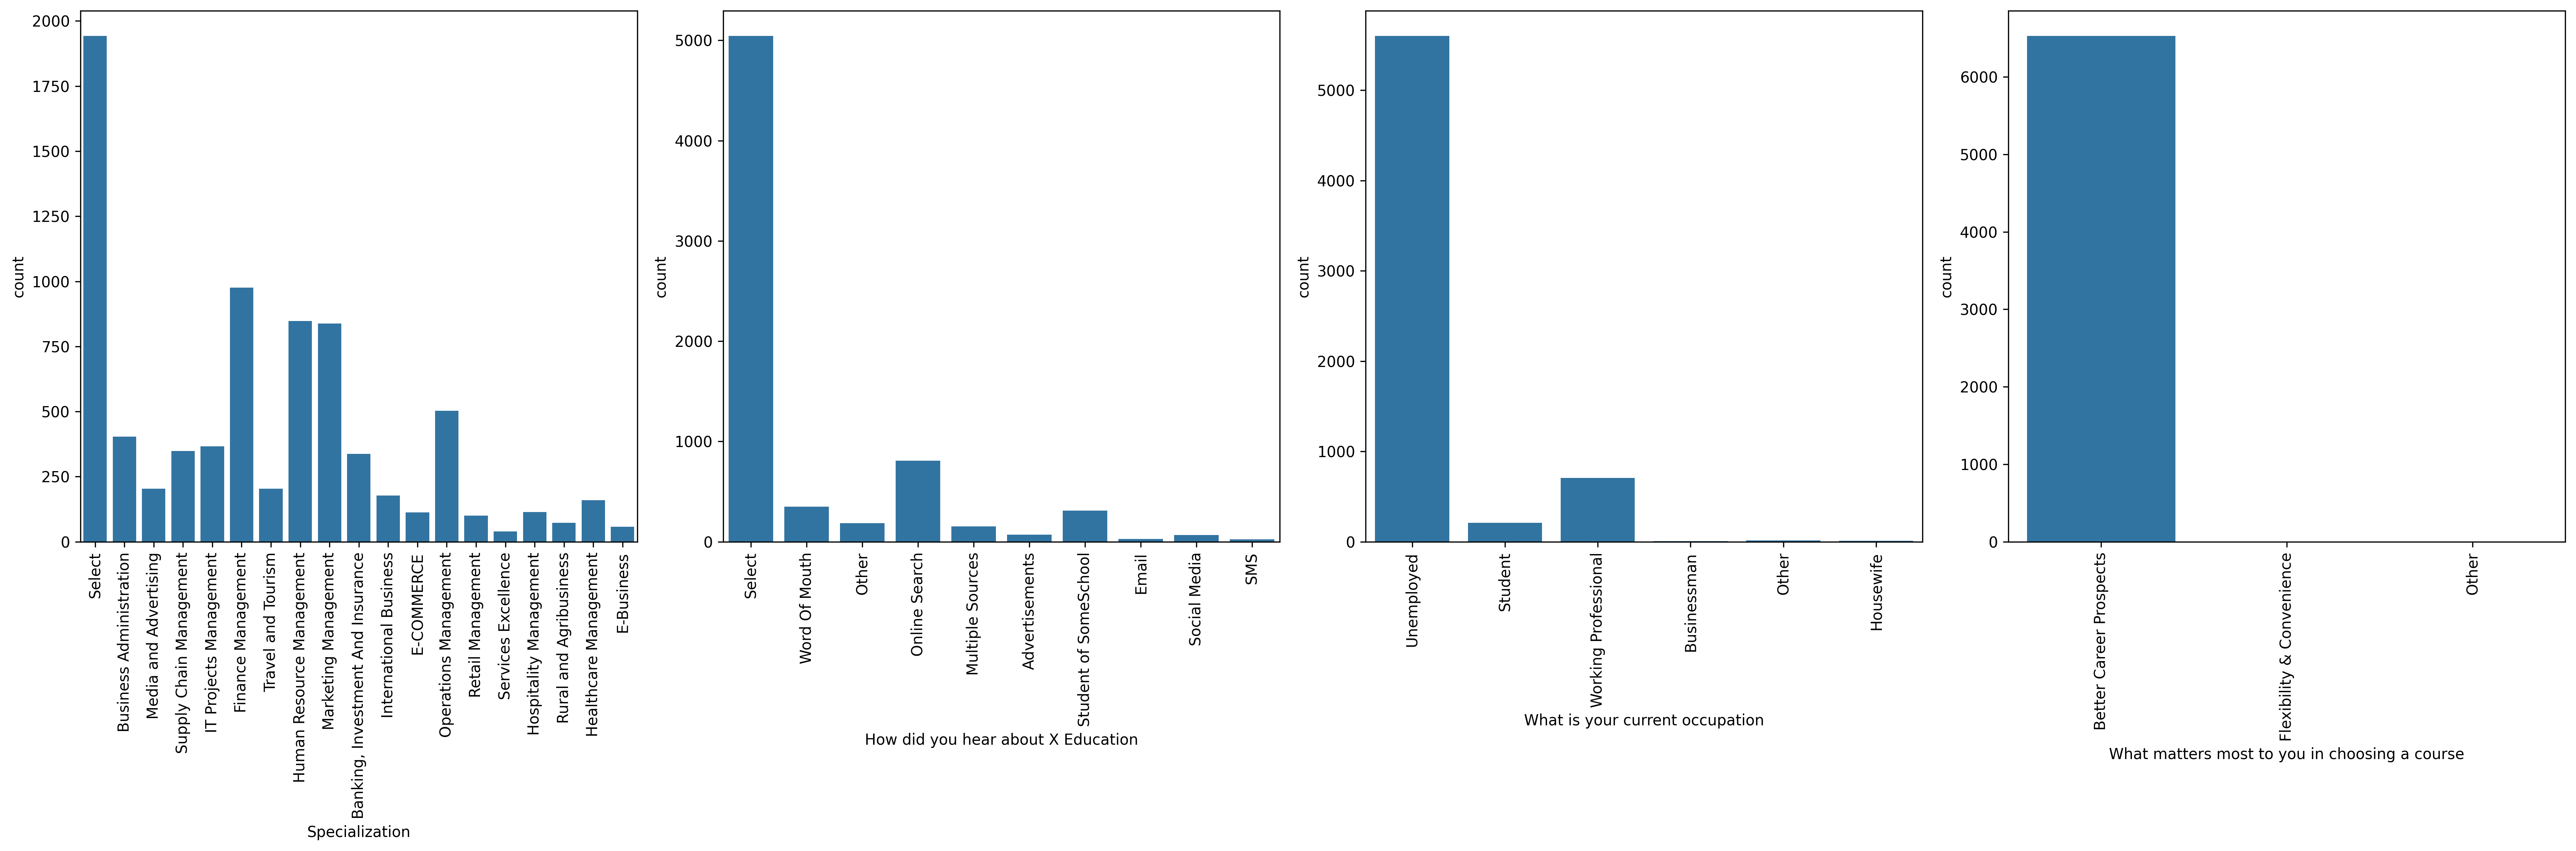

In [22]:
# Let's examine the distribution of the form variables
# We'll make a list of the 4 variables, and then use a for loop to plot them as subplots.

variables = ['Specialization', 'How did you hear about X Education',
             'What is your current occupation','What matters most to you in choosing a course']

fig, ejes = plt.subplots(nrows=1, ncols=4, figsize=(24,8), dpi =300)
for i in range(4):
    sns.countplot(x=variables[i], data = df, ax=ejes[i])
    plt.sca(ejes[i])
    plt.xticks(rotation=90)
plt.tight_layout()

In [23]:
# Replacing 'Select' and missing values with 'Desconocido'

for c in variables:
    df[c].replace('Select', 'Desconocido', inplace = True)
    df[c].fillna('Desconocido', inplace = True)

**Data Type Correction: Update me on Supply Chain Content, Get updates on DM Content**

- **Update me on Supply Chain Content:** Indicates whether the customer wants to receive updates about supply chain content.

- **Get updates on DM Content:** Indicates whether the customer wants to receive updates about DM content.

These features will be easier to handle, interpret, and use in a model by converting them into boolean values.

In [24]:
for c in ['Update me on Supply Chain Content', 'Get updates on DM Content']:
    df[c] = df[c].replace('Yes', 1)
    df[c] = df[c].replace('No', 0)
    df[c] = df[c].astype(bool)

In [25]:
# Remove the 'Tags' variable from the DataFrame
df.drop(columns='Tags', axis = 1, inplace = True)

In [26]:
# Remove the 'Lead Quality' variable
df.drop(columns='Lead Quality', axis = 1, inplace = True)

<Axes: xlabel='count', ylabel='Lead Profile'>

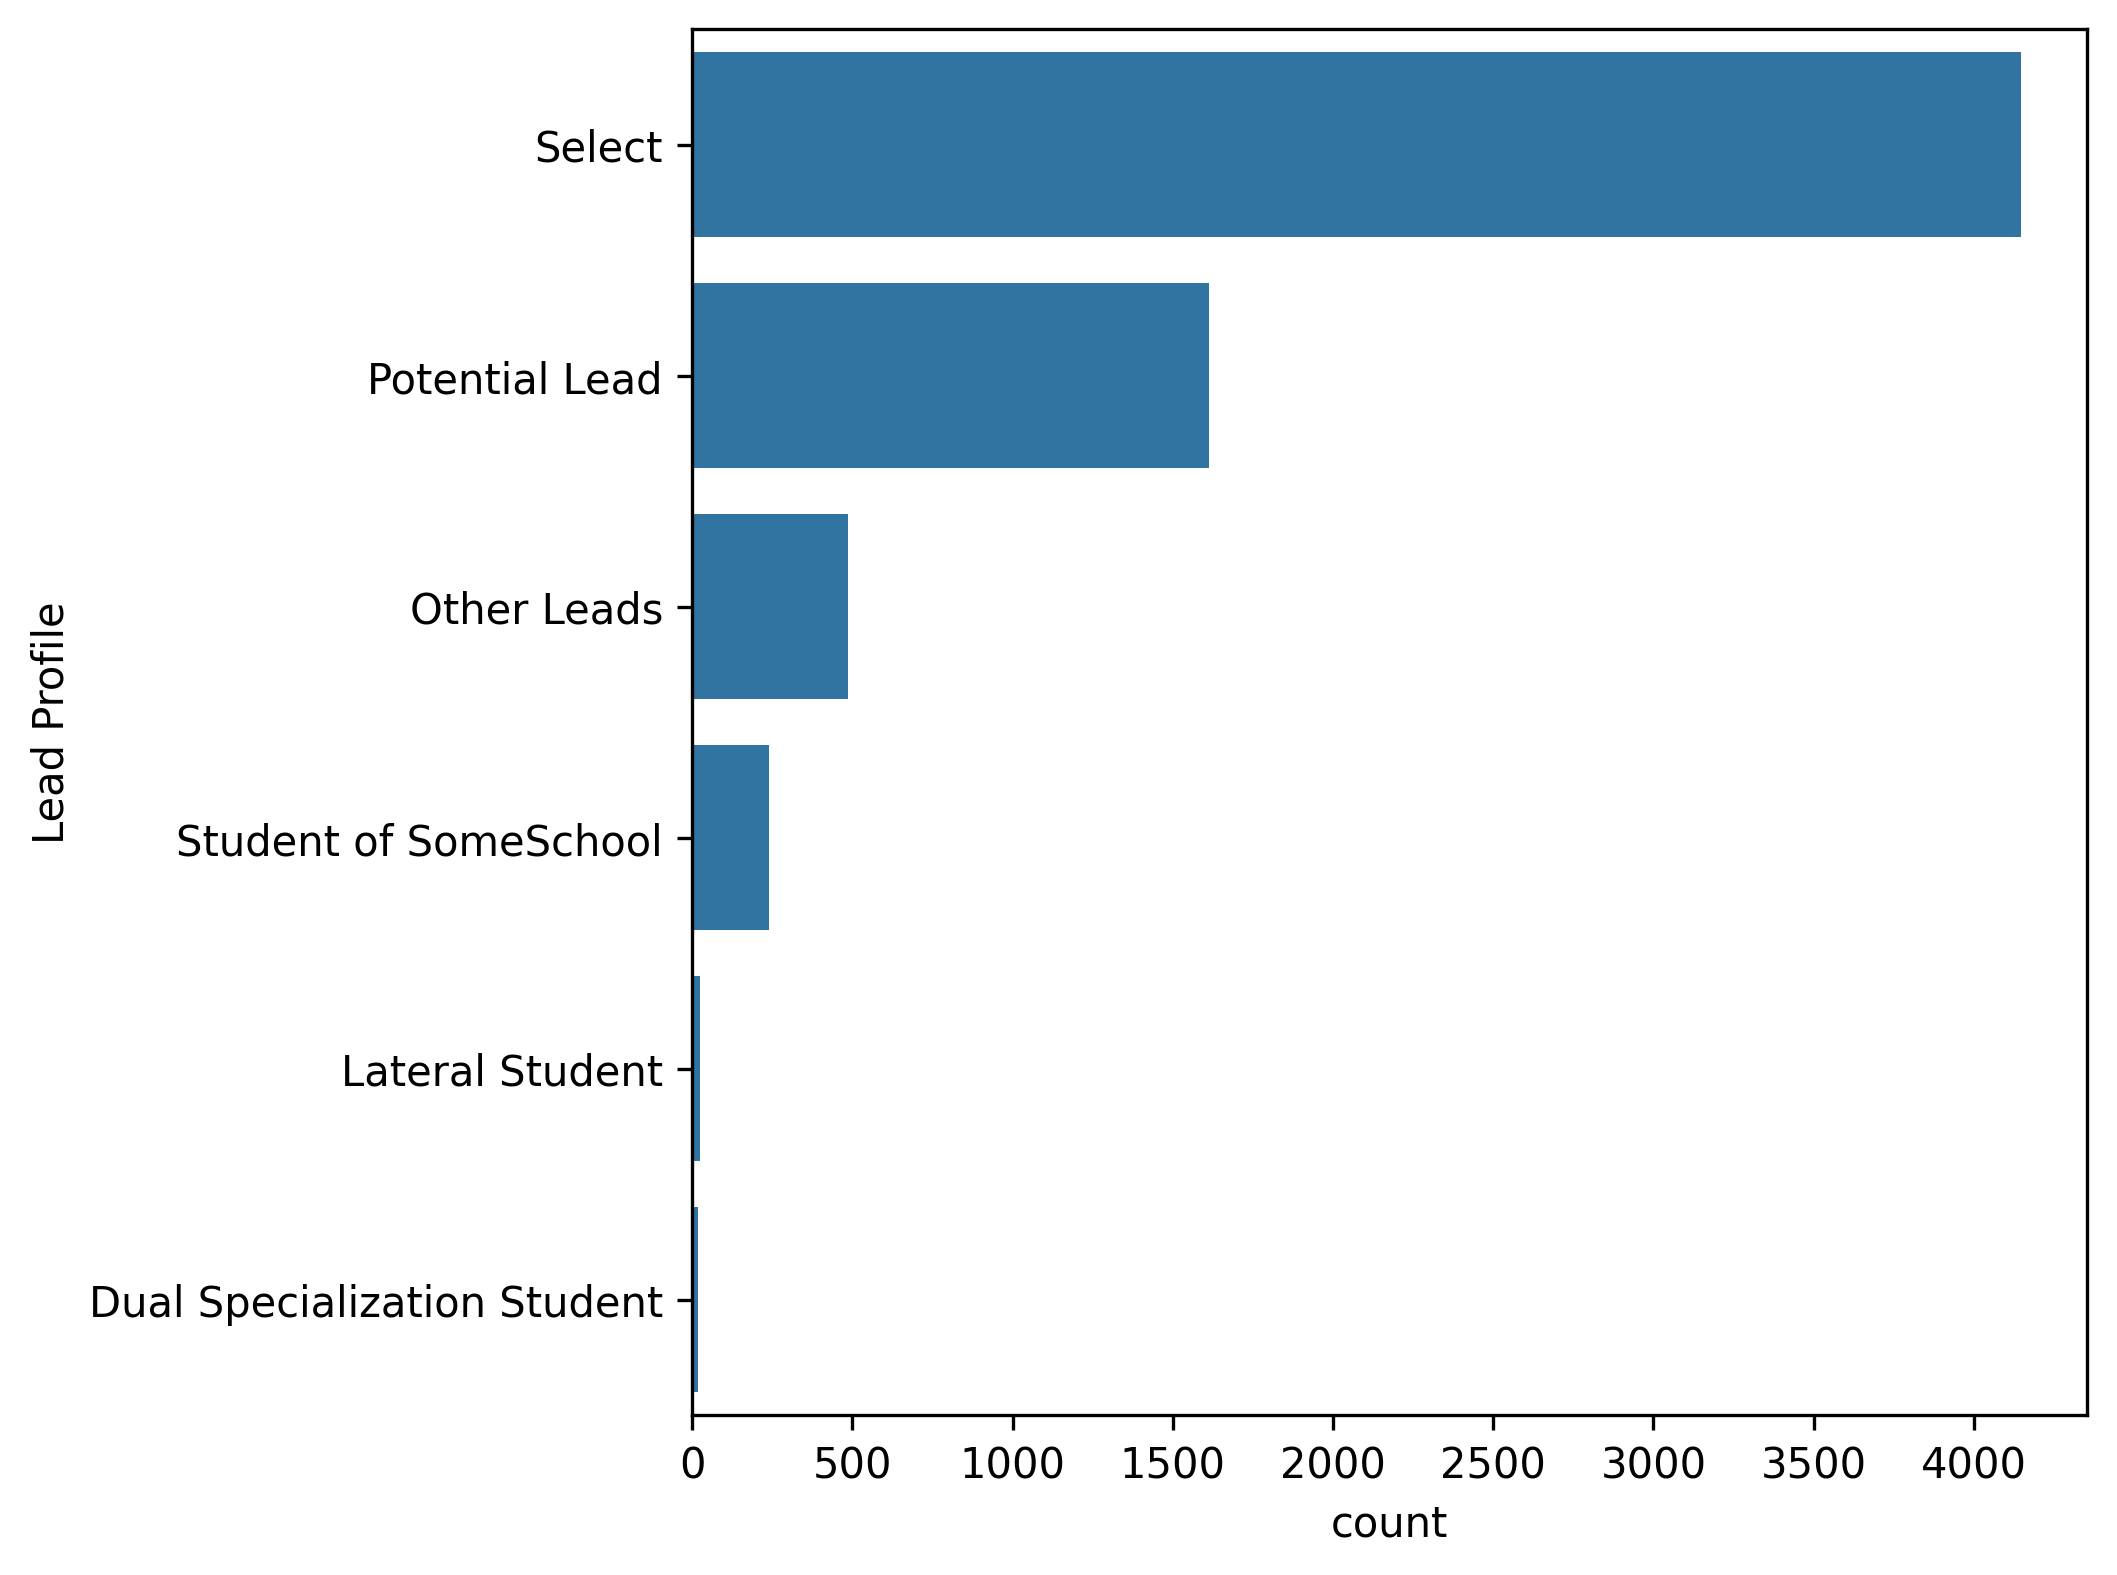

In [27]:
# Lead Profile Distribution Chart
plt.figure(figsize = (6, 6), dpi = 300)
sns.countplot(y='Lead Profile', data = df, order = df['Lead Profile'].value_counts().index)

<Axes: xlabel='count', ylabel='City'>

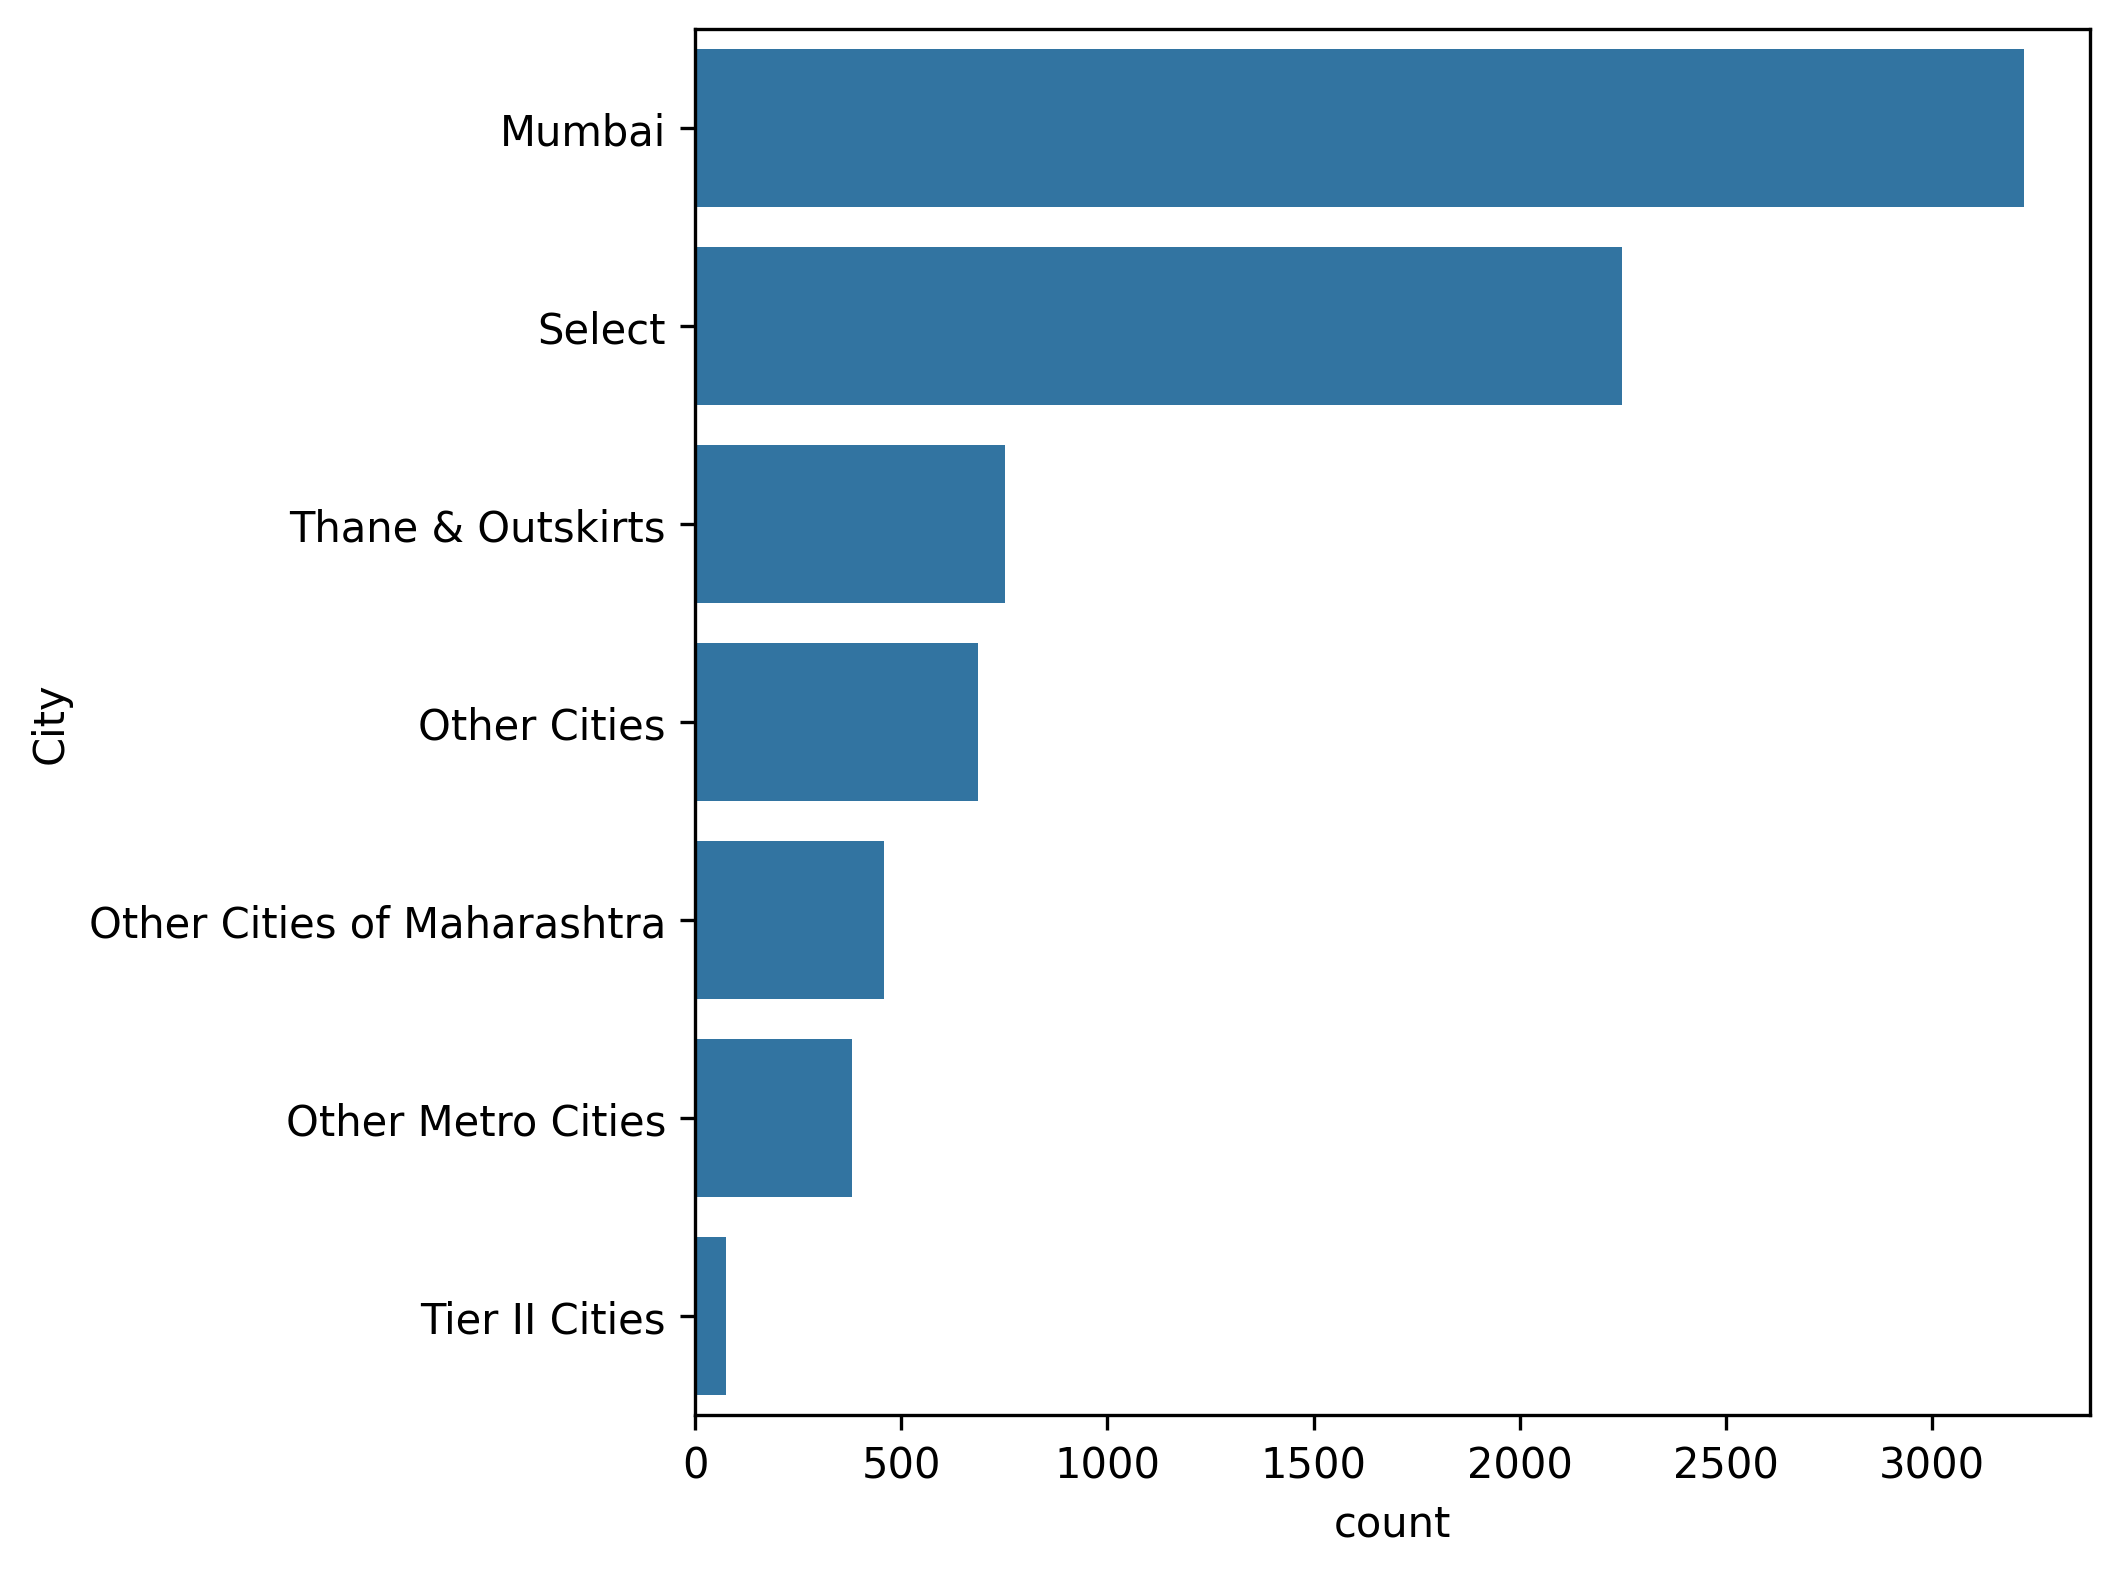

In [28]:
# Replace 'Select' with 'Desconocido'
# Fill missing values with 'Desconocido'

df['Lead Profile'].replace('Select', 'Desconocido', inplace = True)
df['Lead Profile'].fillna('Desconocido', inplace=True)

plt.figure(figsize = (6, 6), dpi = 300)
sns.countplot(y='City', data = df, order = df['City'].value_counts().index)

A large portion of the values are "Select," which is equivalent to a null.

In [29]:
# Replace 'Select' with 'Desconocido'
# Fill missing values with 'Desconocido'

df['City'].replace('Select', 'Desconocido', inplace = True)
df['City'].fillna('Desconocido', inplace=True)

In [30]:
# Convert Yes/No variables to boolean values

for c in ['I agree to pay the amount through cheque', 'A free copy of Mastering The Interview']:
    df[c] = df[c].replace('Yes', 1)
    df[c] = df[c].replace('No', 0)
    df[c] = df[c].astype(bool)

In [31]:
# Convert string (object) data to categorical data type

for c in df.columns:
    if df[c].dtype == 'object':
        df[c] = df[c].astype('category')

In [32]:
# Descriptive statistics of the scores

estadisticas_scores = pd.DataFrame(
    {'Assymmetrique Activity Score': df['Asymmetrique Activity Score'].describe(),
    'Asymmetrique Profile Score': df['Asymmetrique Profile Score'].describe()})

estadisticas_scores

Assymmetrique Activity Score  Asymmetrique Profile Score
count                   5022.000000                 5022.000000
mean                      14.306252                   16.344883
std                        1.386694                    1.811395
min                        7.000000                   11.000000
25%                       14.000000                   15.000000
50%                       14.000000                   16.000000
75%                       15.000000                   18.000000
max                       18.000000                   20.000000

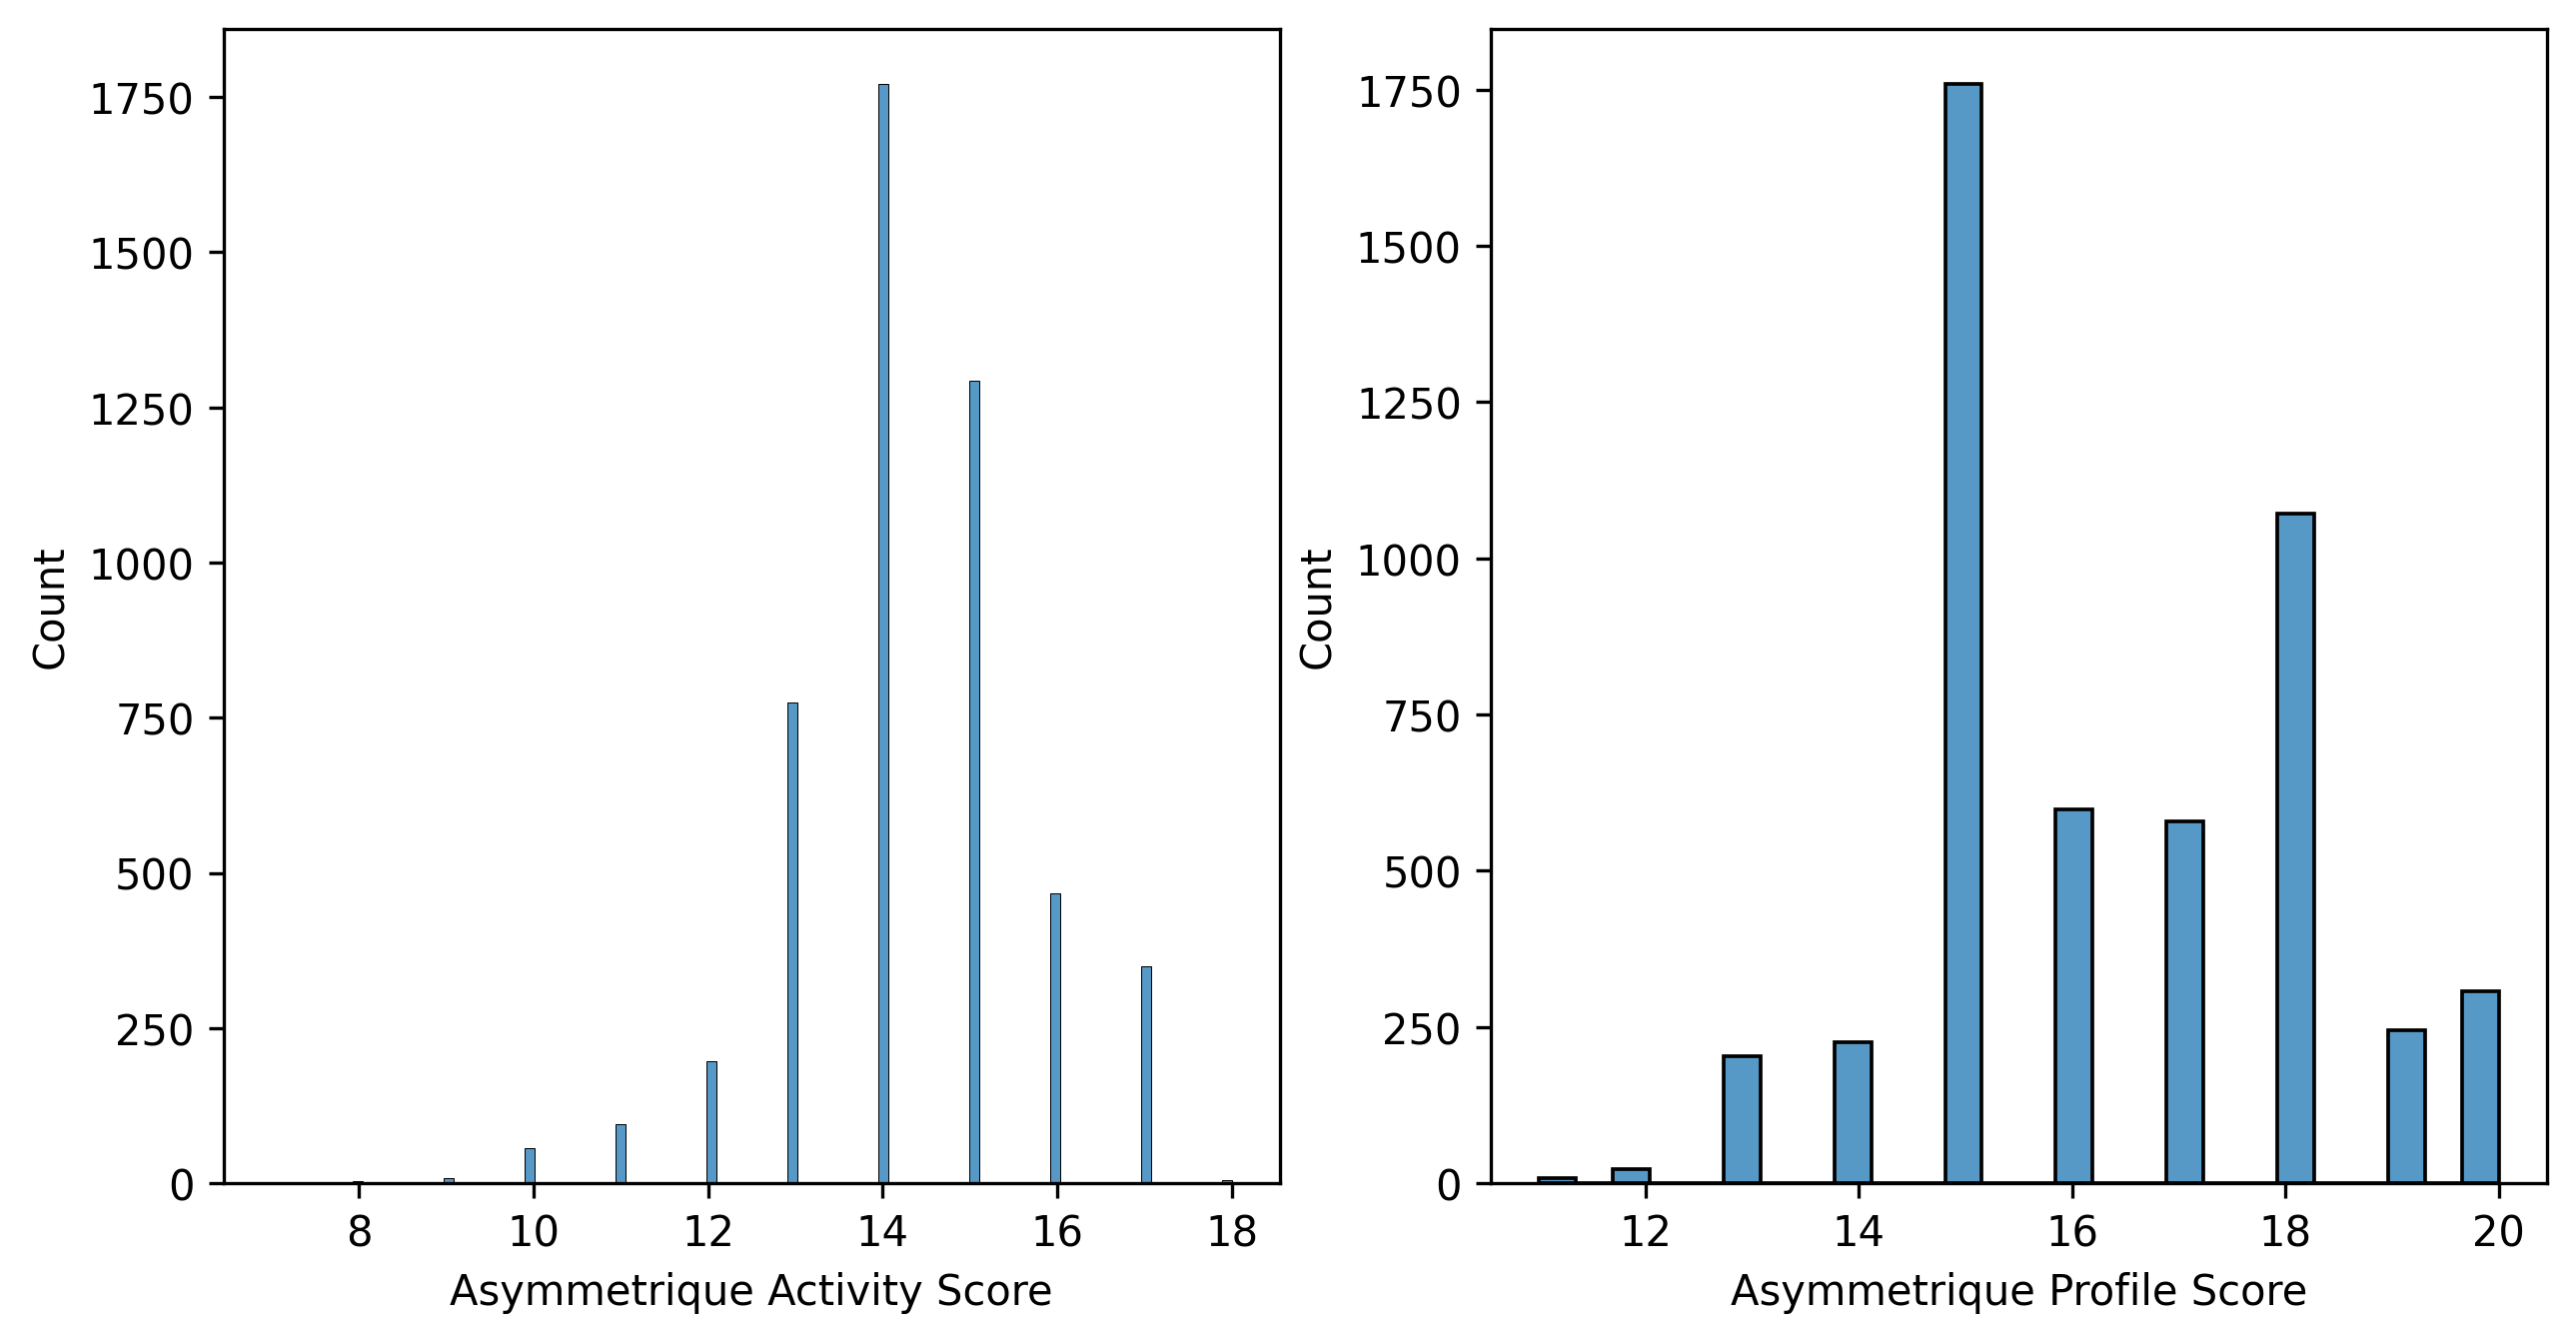

In [33]:
# Noting that the median is slightly to the left (i.e., lower) than the mean in both cases. To confirm,
# let's create a histogram

# Plot the distribution of the scores

scores = ['Asymmetrique Activity Score','Asymmetrique Profile Score']
fig, ejes = plt.subplots(nrows=1, ncols=2, figsize=(10,5), dpi = 300)
for i in range(2):
    sns.histplot(x=scores[i], data = df, ax=ejes[i])

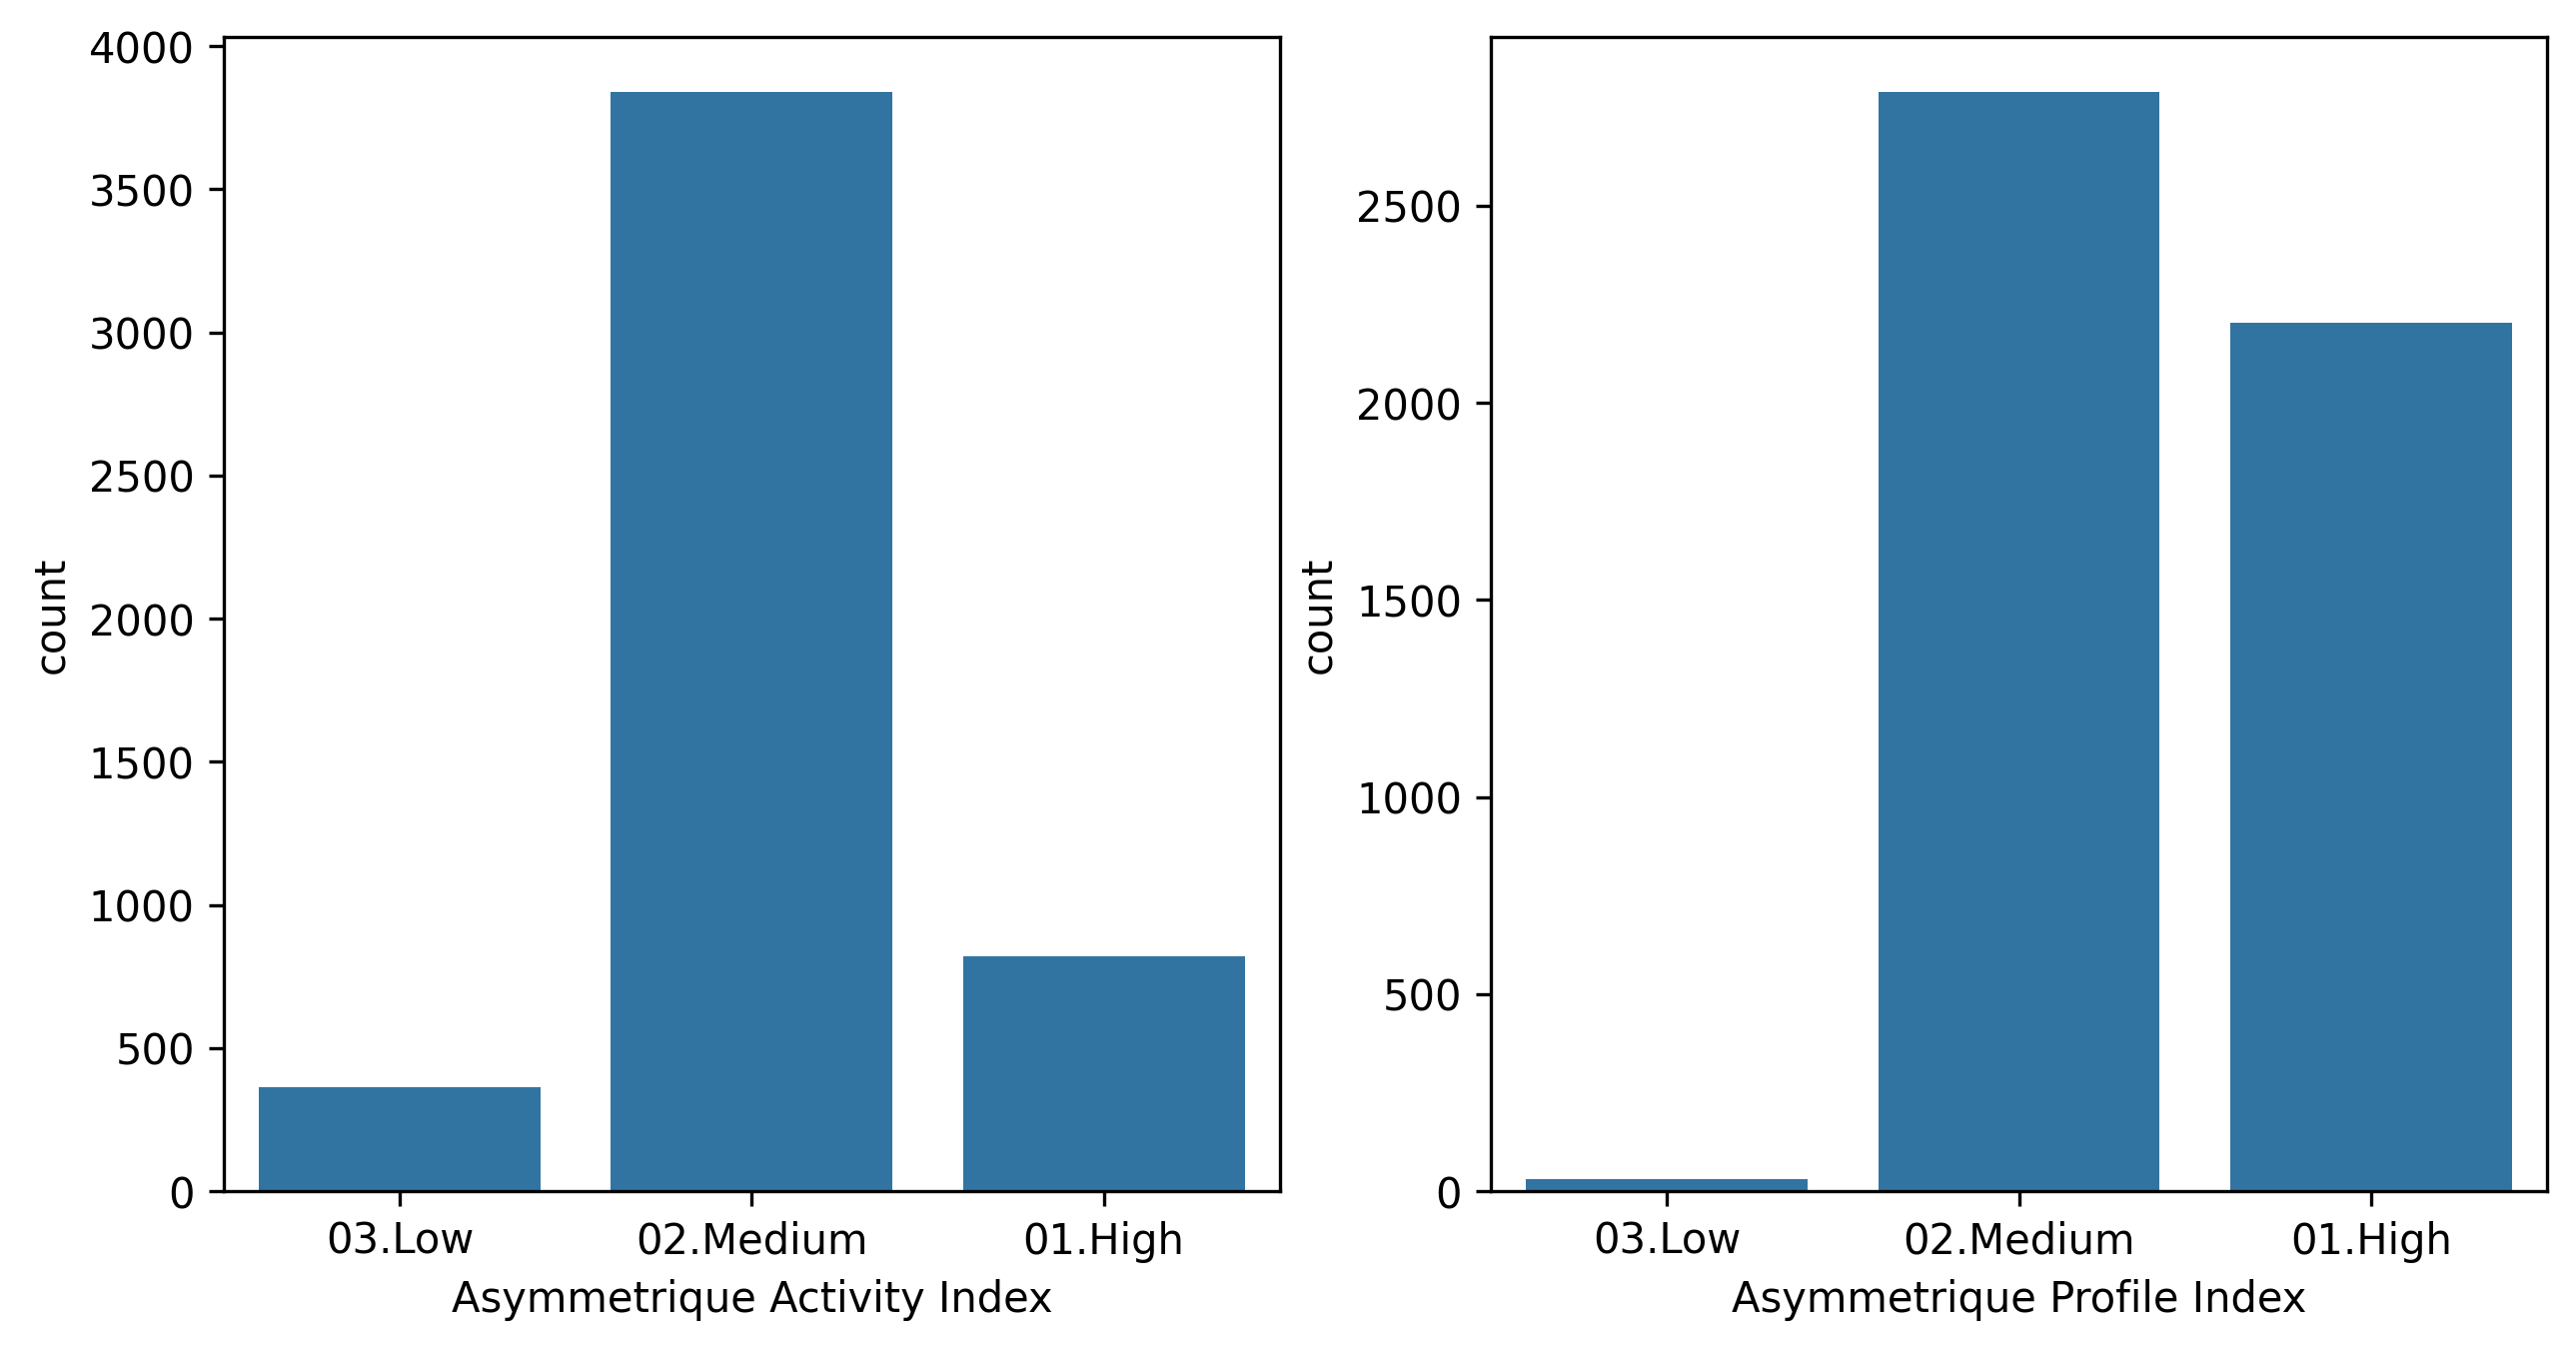

In [34]:
# Both are skewed, so it would be more appropriate to fill missing values with the median rather than the mean

for s in scores:
    df[s].fillna(df[s].median(), inplace = True)
    
indices = ['Asymmetrique Activity Index','Asymmetrique Profile Index']

fig, ejes = plt.subplots(nrows=1, ncols=2, figsize=(10,5), dpi = 300)
for i in range(2):
    sns.countplot(x=indices[i], data = df, ax=ejes[i], order = ['03.Low','02.Medium','01.High'])

It seems that the index features may simply be grouped according to the Asymmetric Score, in which case both index features are redundant. We can confirm this by examining the average Asymmetric Score by Asymmetric Index.

In [35]:
agrupados_por_activity_index = df.groupby('Asymmetrique Activity Index').agg({'Asymmetrique Activity Score':'mean'})
agrupados_por_activity_index

Asymmetrique Activity Score
Asymmetrique Activity Index                             
01.High                                        16.437272
02.Medium                                      14.134931
03.Low                                         11.290055

In [36]:
agrupados_por_profile_index = df.groupby('Asymmetrique Profile Index').agg({'Asymmetrique Profile Score':'mean'})
agrupados_por_profile_index

Asymmetrique Profile Score
Asymmetrique Profile Index                            
01.High                                      18.128007
02.Medium                                    14.987446
03.Low                                       11.709677

As can be seen from the calculations above, the Asymmetrique Activity/Profile Index values ​​appear to simply group the Asymmetrique Activity/Profile Scores together. As a result, index features are redundant and can be removed.

In [37]:
# Let's drop the index columns
df.drop(columns=['Asymmetrique Profile Index','Asymmetrique Activity Index'], axis=1, inplace=True)

# And confiirm what are we ddoing on the info
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9240 entries, 660737 to 579533
Data columns (total 31 columns):
 #   Column                                         Non-Null Count  Dtype   
---  ------                                         --------------  -----   
 0   Lead Origin                                    9240 non-null   category
 1   Lead Source                                    9240 non-null   category
 2   Do Not Email                                   9240 non-null   bool    
 3   Do Not Call                                    9240 non-null   bool    
 4   Converted                                      9240 non-null   bool    
 5   TotalVisits                                    9240 non-null   float64 
 6   Total Time Spent on Website                    9240 non-null   int64   
 7   Page Views Per Visit                           9240 non-null   float64 
 8   Last Activity                                  9240 non-null   category
 9   Country                                

# Exploratory Analysis of Categorical Variables

In [38]:
# We create the function count_of_converts: It will make a bar graph (countplot) comparing the converted and non-converted
# for the respective independent variable. It will be very useful for categorical variables.

def conteo_de_convertidos(independiente, dependiente = 'Converted'):
    plt.figure(figsize=(6,6), dpi = 300)
    sns.countplot(y=independiente, data = df, hue= dependiente, order = df[independiente].value_counts().index)
    plt.title("Distribución de la variable categórica " + independiente + " por Convertidos")
    plt.show()

In [39]:
# Now let's calculate the lead conversion ratio across the entire data
tasa_de_conversion = round(df['Converted'].mean(), 2)
tasa_de_conversion

0.39

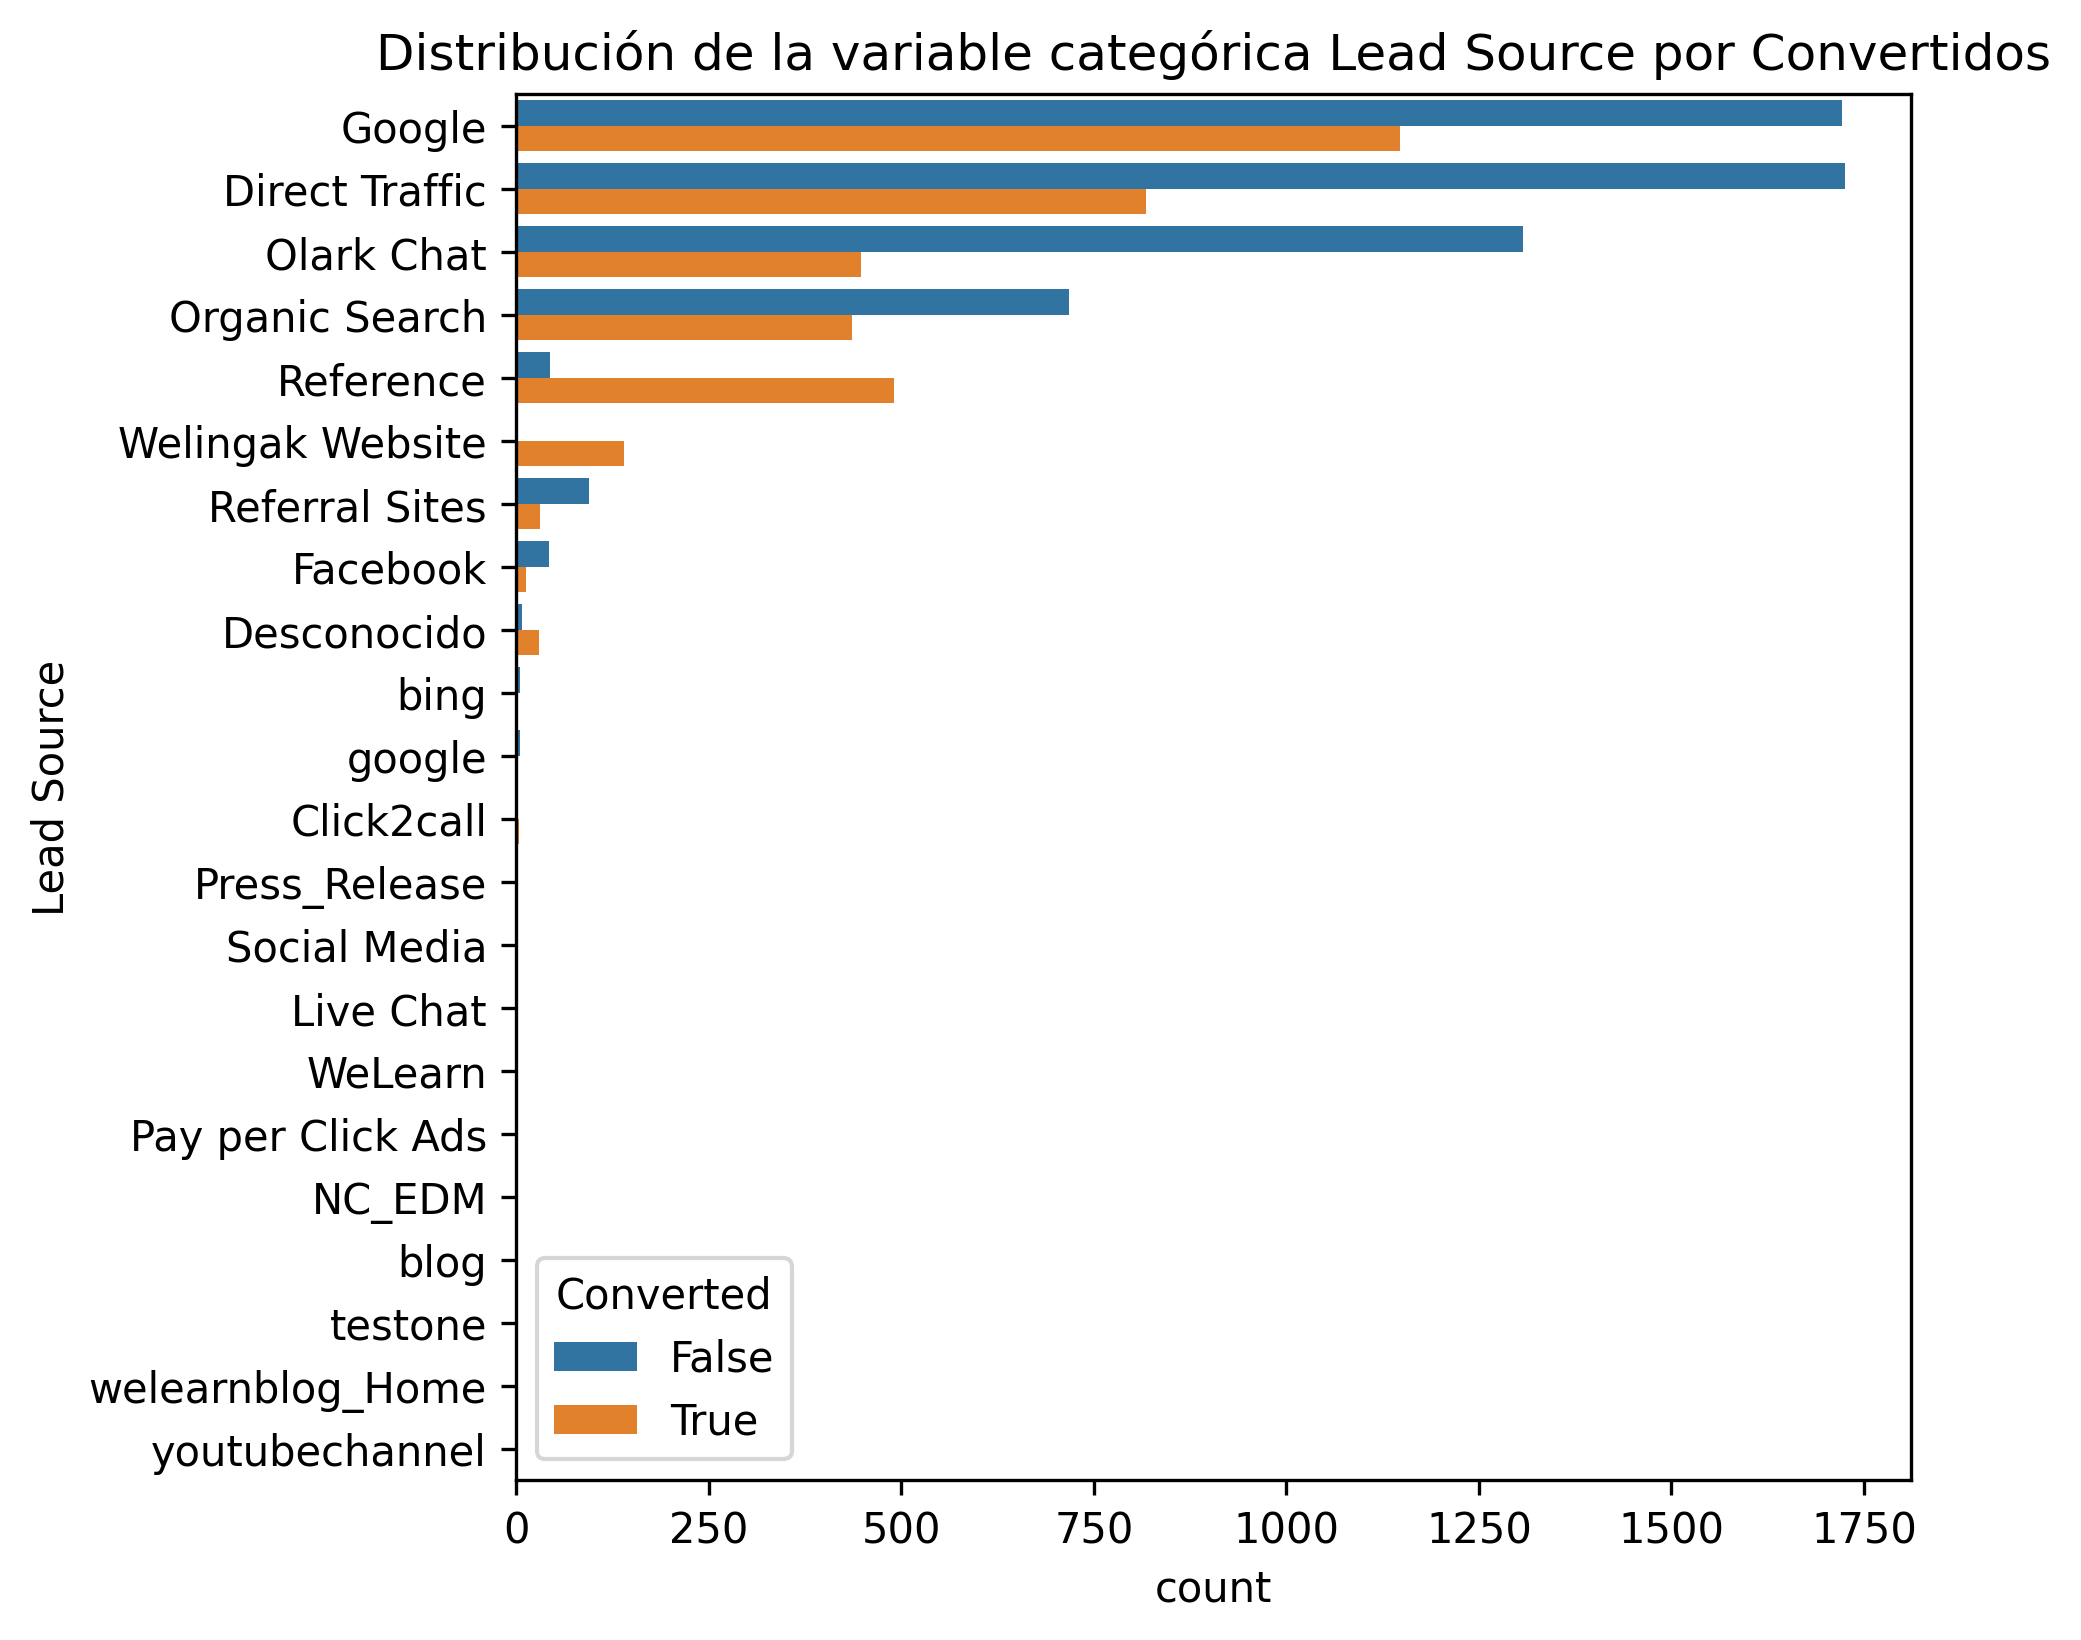

In [40]:
# Exploratory Analysis of a Variable: Lead Source
conteo_de_convertidos('Lead Source')


Observations

The conversion rate appears to be higher for leads that come from the Wellingak website or are referred.

Increasing the number of leads referred to and coming from the Wellingak website is likely to increase the overall conversion rate.

Although Google and Direct Traffic are the source of a similar number of leads, the conversion rate appears to be higher among leads that come from Google.

There are fewer leads from Organic Search as a source than from Google, but leads that come from both sources appear to have a similar conversion rate.

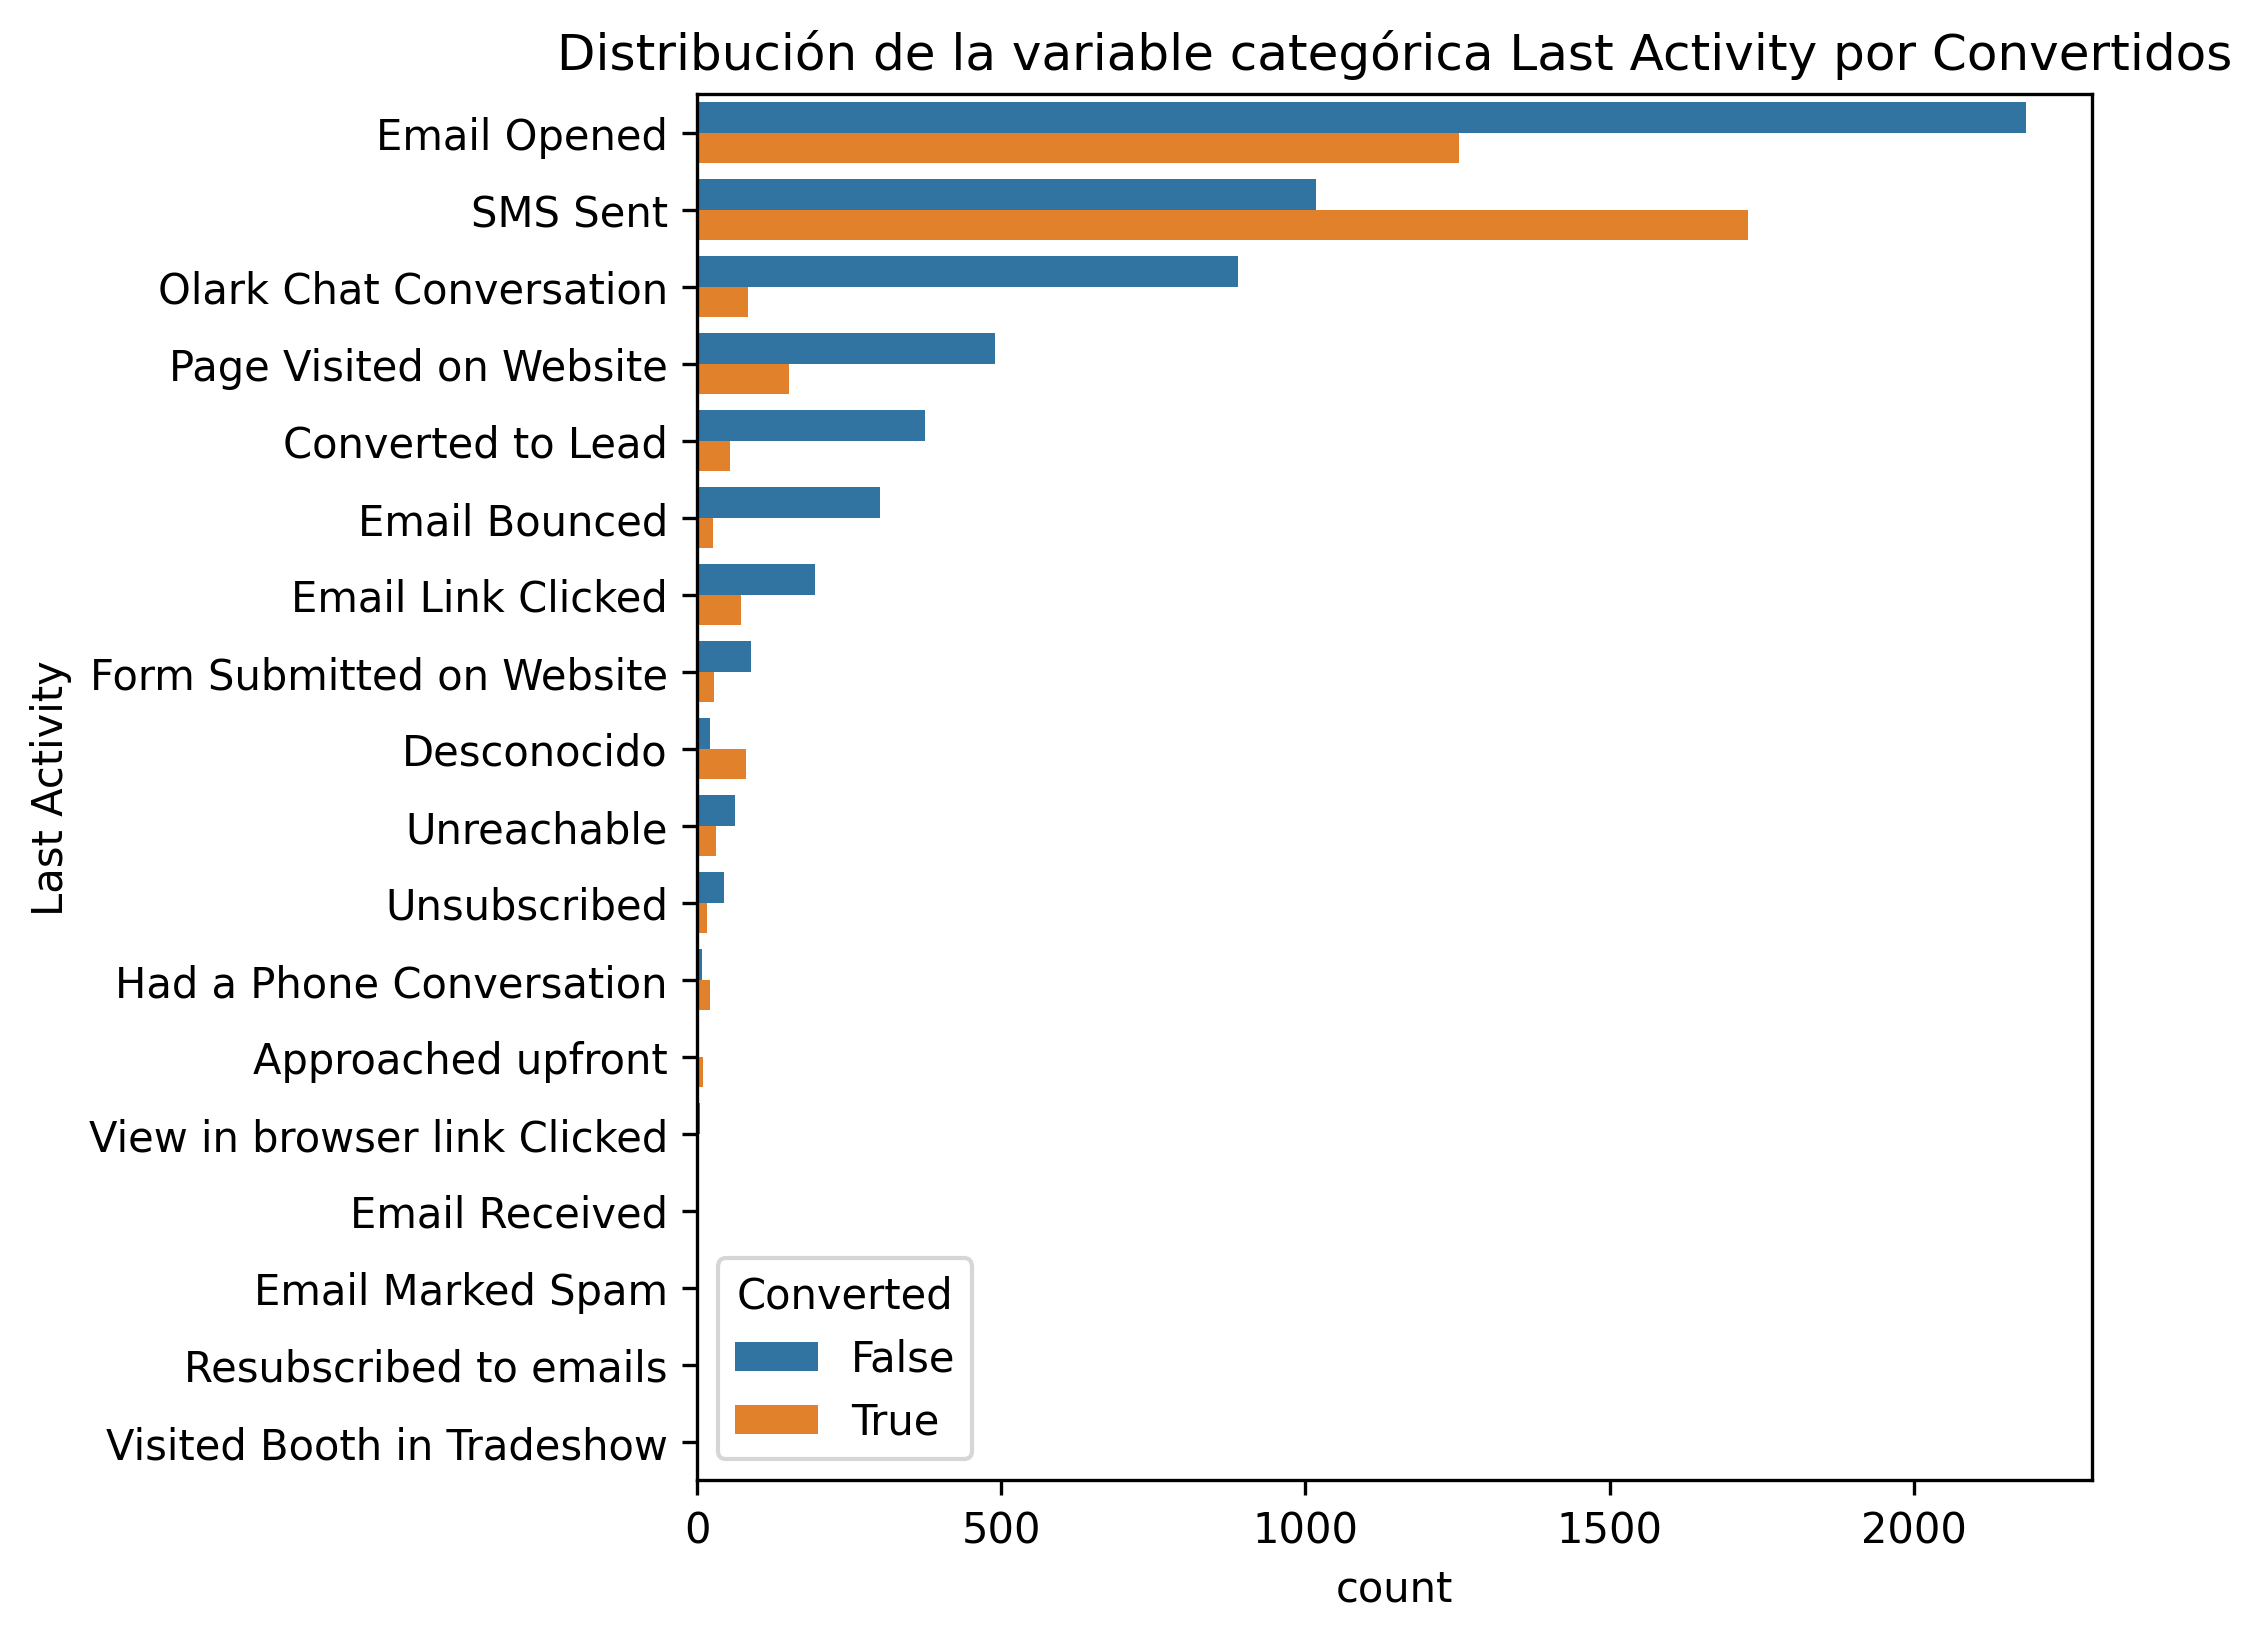

In [41]:
# Exploratory Analysis of a Variable: Last Activity
conteo_de_convertidos('Last Activity')

The Last Activity with the highest conversion rate by far is Sending SMS.

Further investigation is required to determine whether this is a result of the effectiveness of this activity or simply the stage at which it occurs in the lead nurturing process.

In [42]:
# Exploratory Analysis of a Variable: Lead Origin

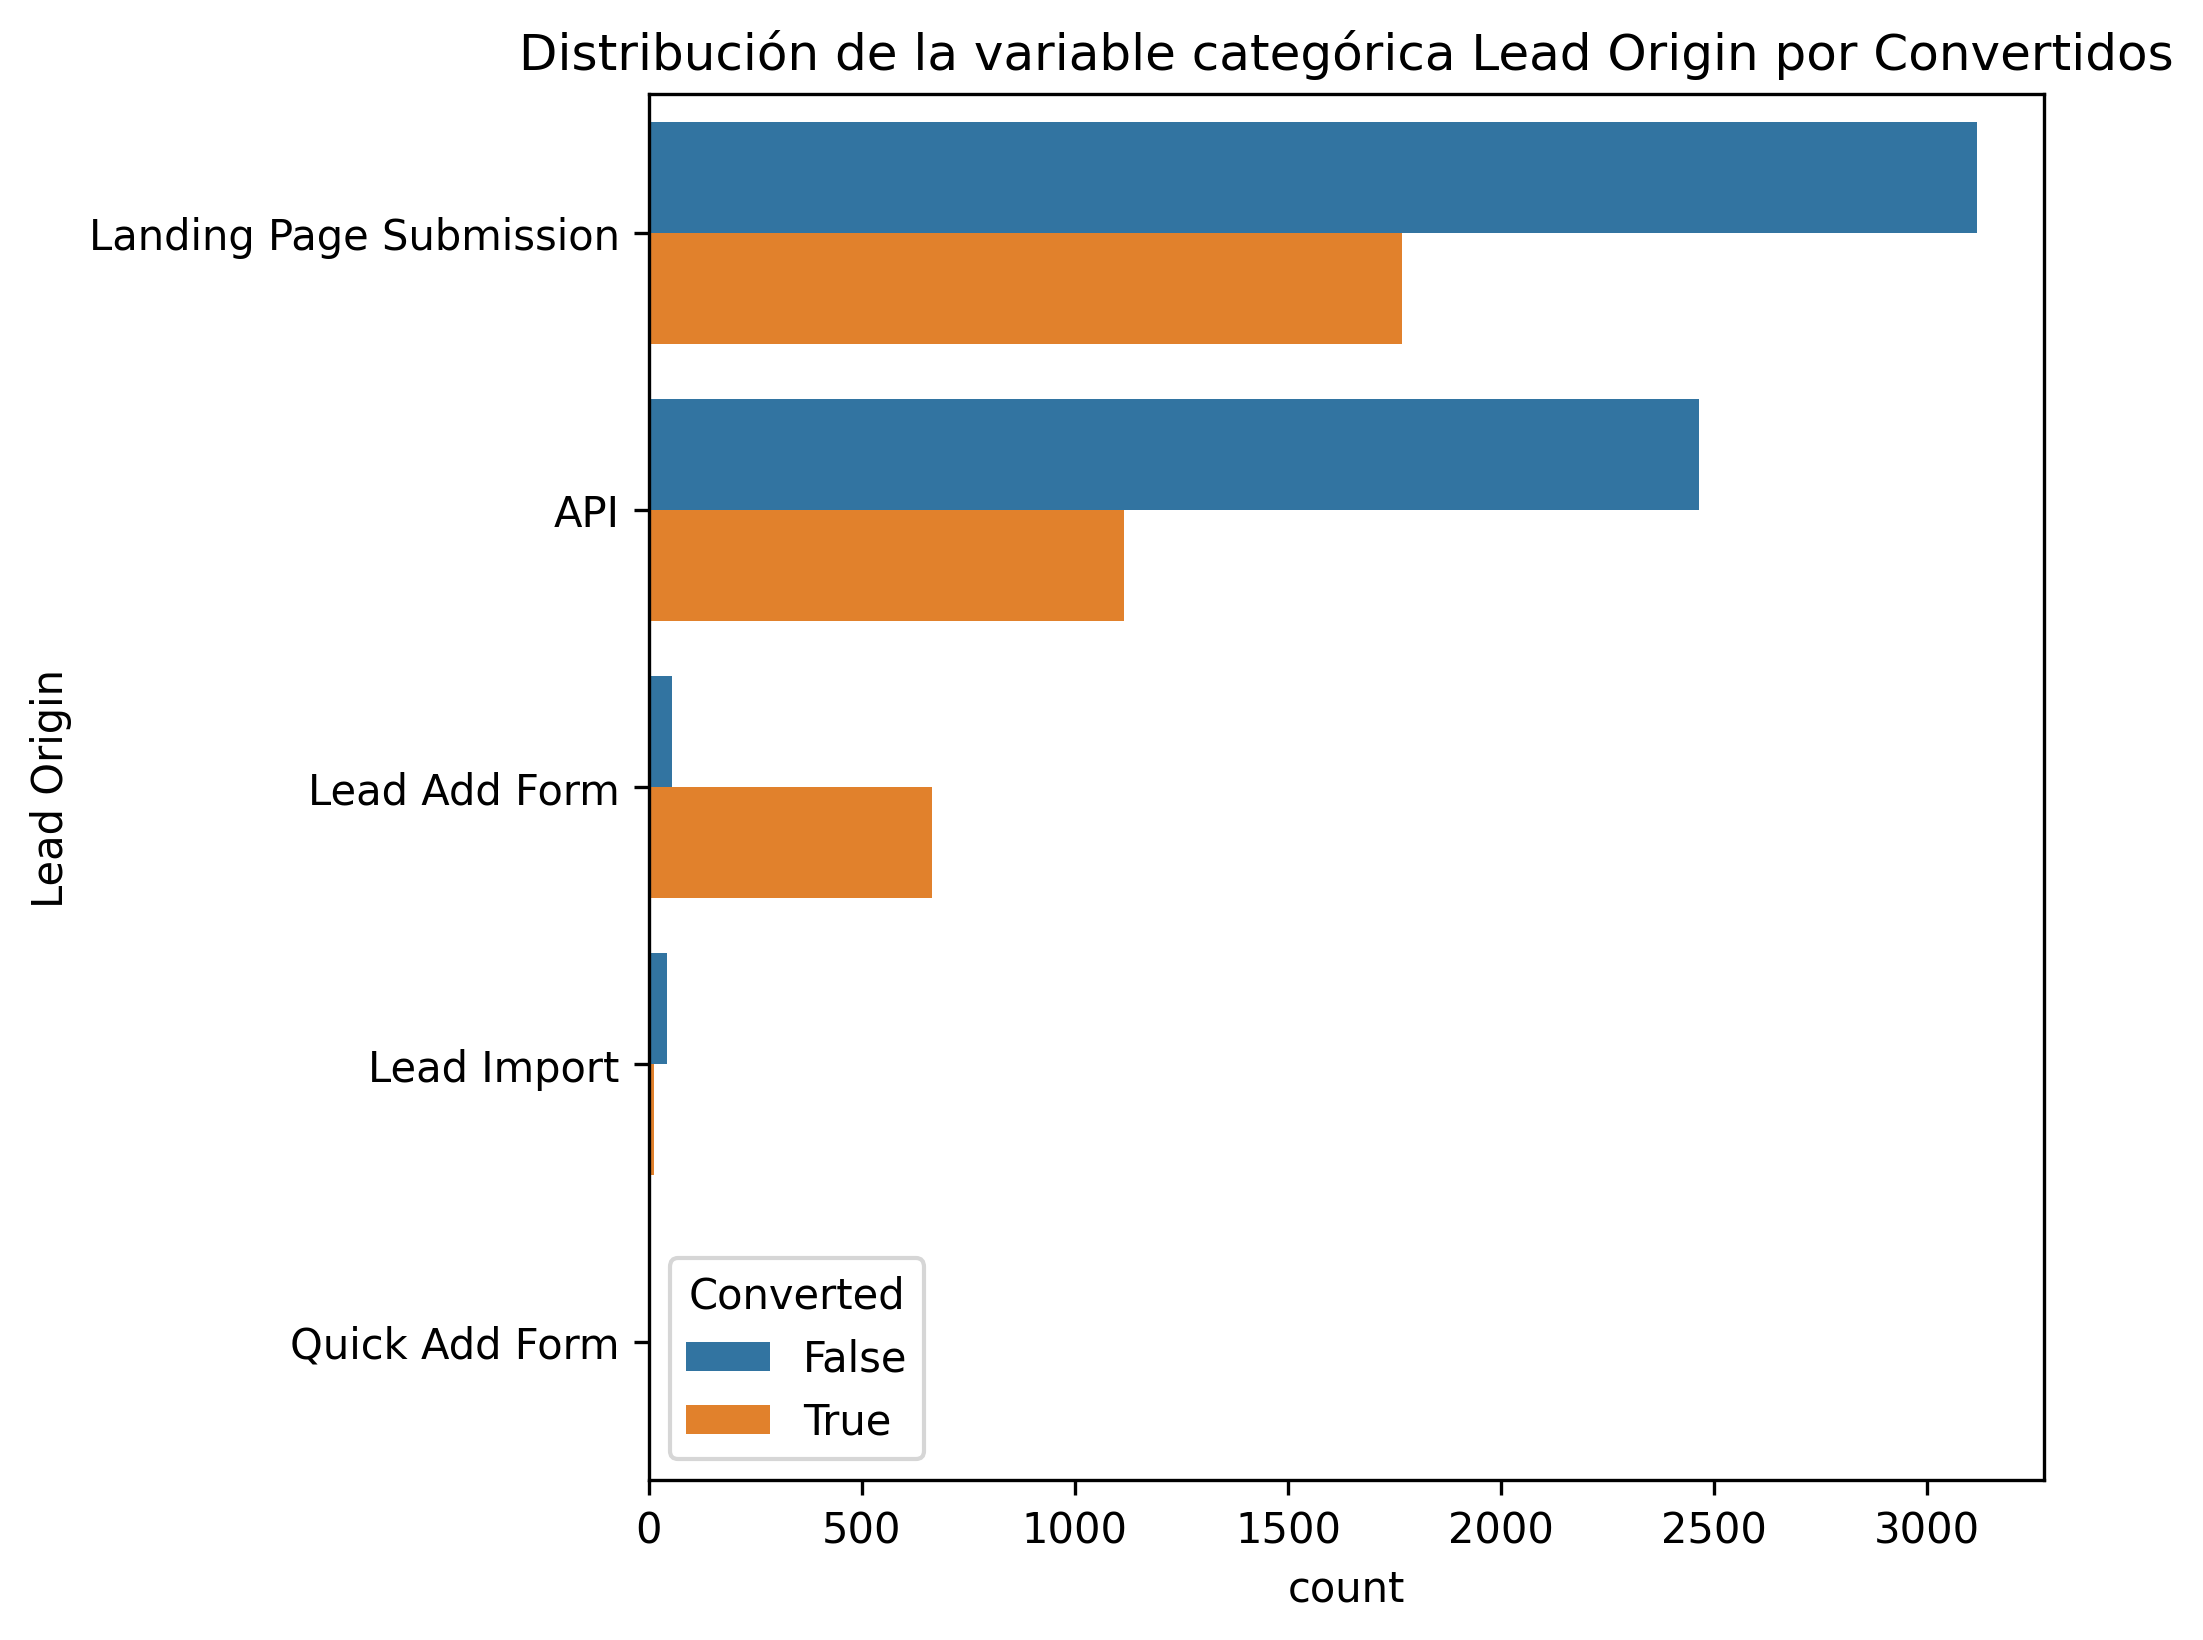

In [43]:
conteo_de_convertidos('Lead Origin')

Significantly more leads convert when they originate through the 'Add Lead' form. 

The lead conversion rate appears to be slightly higher among those originating from 'Landing Page Submission' than from 'API'.

# Exploratory Analysis of Boolean Variables

In [44]:
# We create the function confusion_matrix to plot the heat map of the confusion matrix of a feature 

def matriz_de_confusion(independiente, dependiente = 'Converted'):
    mdc=confusion_matrix(df[independiente], df[dependiente])
    plt.figure(figsize=(4,4), dpi = 300)
    sns.heatmap(mdc, annot=True, fmt='', xticklabels=['No','Yes'], yticklabels=['No','Yes'], cmap='Blues')
    plt.title("Matriz de Confusión " + independiente + " vs. " + dependiente)
    plt.xlabel(dependiente)
    plt.ylabel(independiente)
    plt.show()

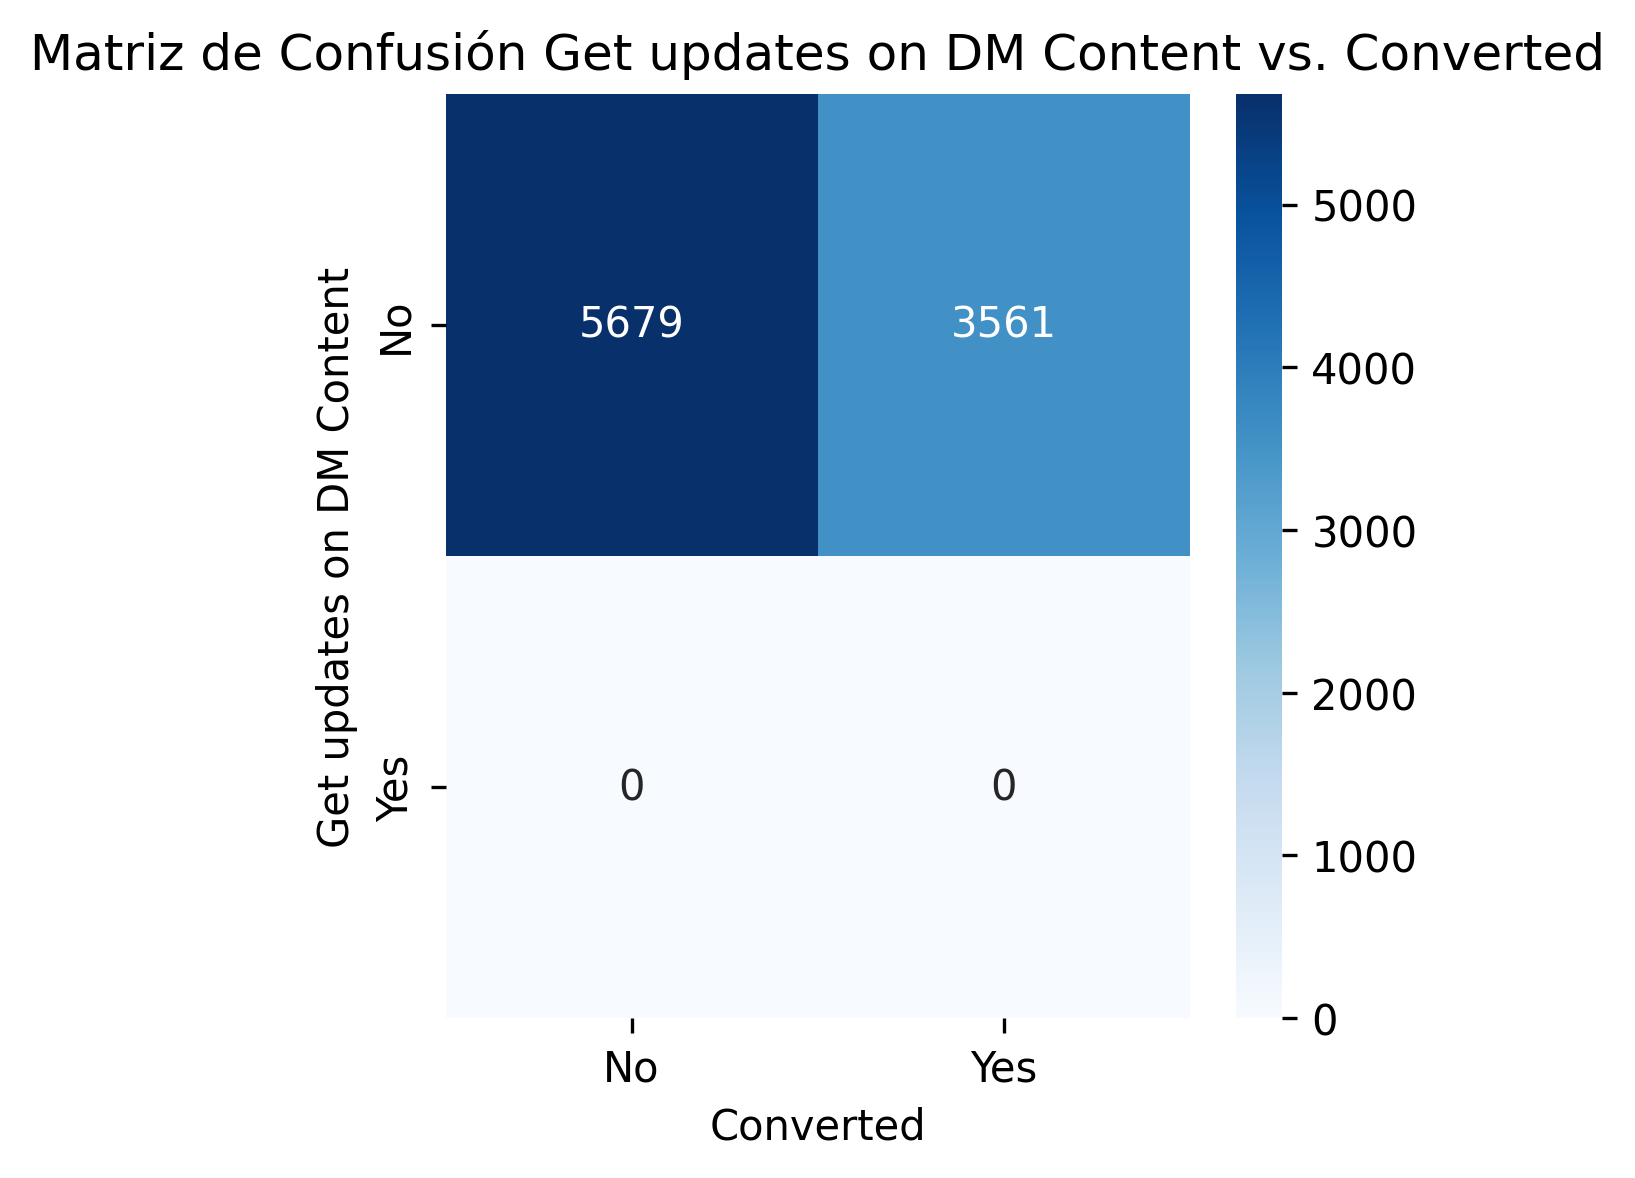

In [45]:
# Confusion Matrix of 'Get updates on DM Content' vs. 'Converted'
matriz_de_confusion('Get updates on DM Content')

No prospects indicated they wanted to receive updates on DM (Direct Marketing) content.
Sending this type of content to prospects is obviously not in their interest, both for those who did not sign up and for those who finally did sign up.

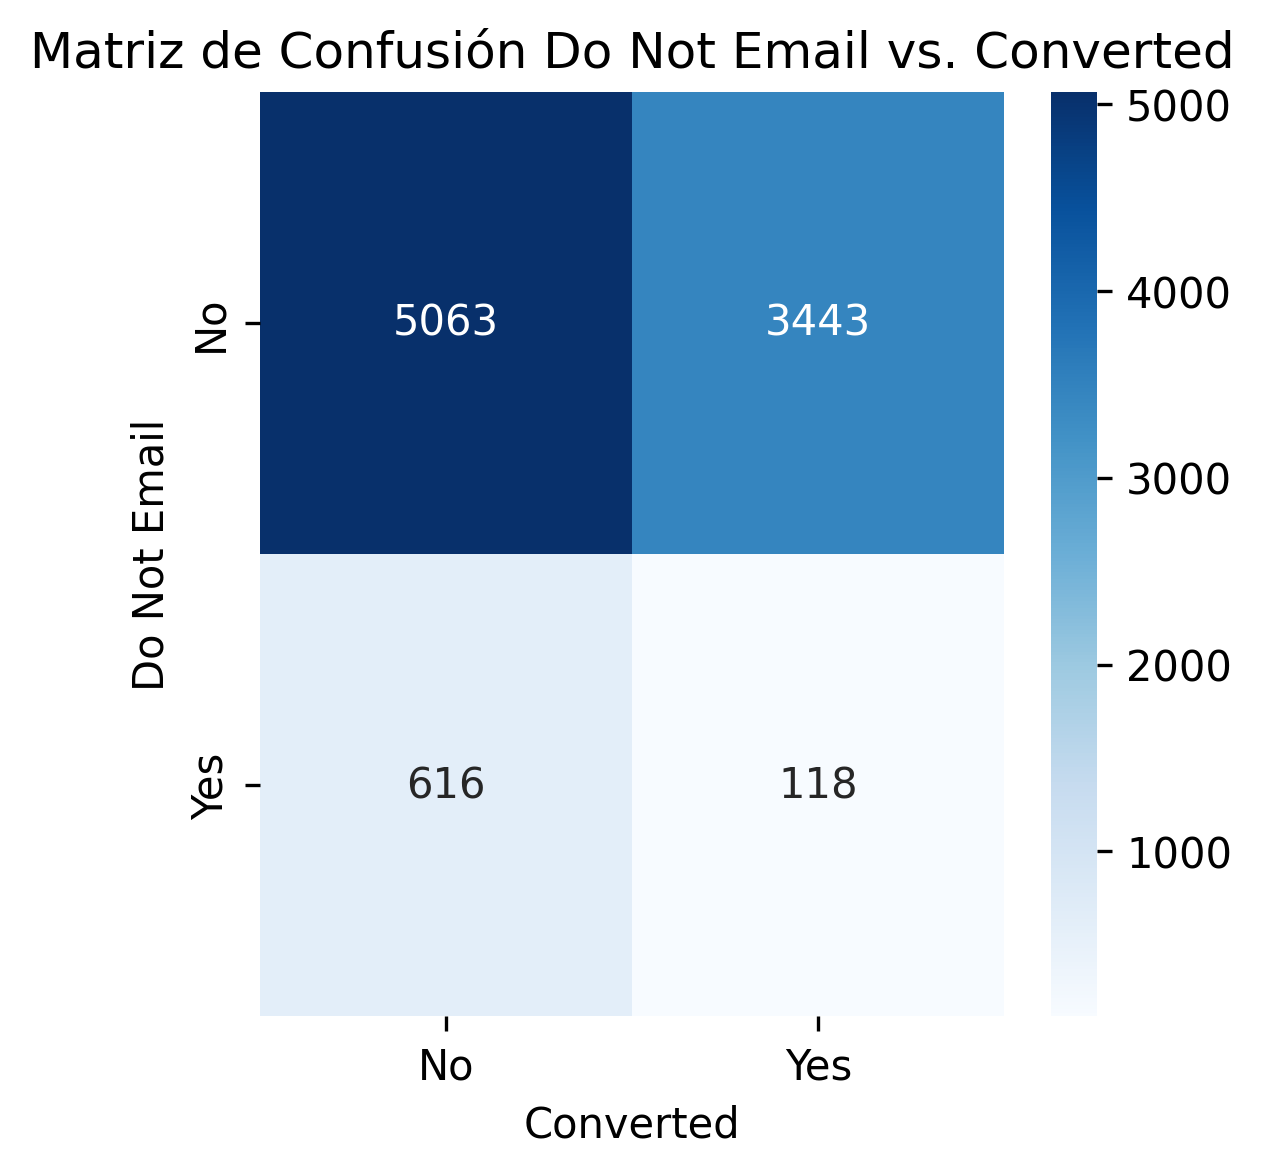

In [46]:
# Do not email vs "Converted"
matriz_de_confusion('Do Not Email')

The majority of prospects indicate “No” to the Do Not Email option, suggesting that the sales team is free to contact them via email.

The conversion rate among prospects who indicate “No” to the Do Not Call option is 40.47% = 3443/(5063+3443)

Very few prospects have a “Yes” to the Do Not Email option (7.94% = (616+118)/9240). The conversion rate between these is only 16.08% = 118/(616+118). Since they indicate not to be contacted we can see their lack of interest in signing up.

In [47]:
# Confusion Matrix of 'A free copy of Mastering The Interview' vs. 'Converted'

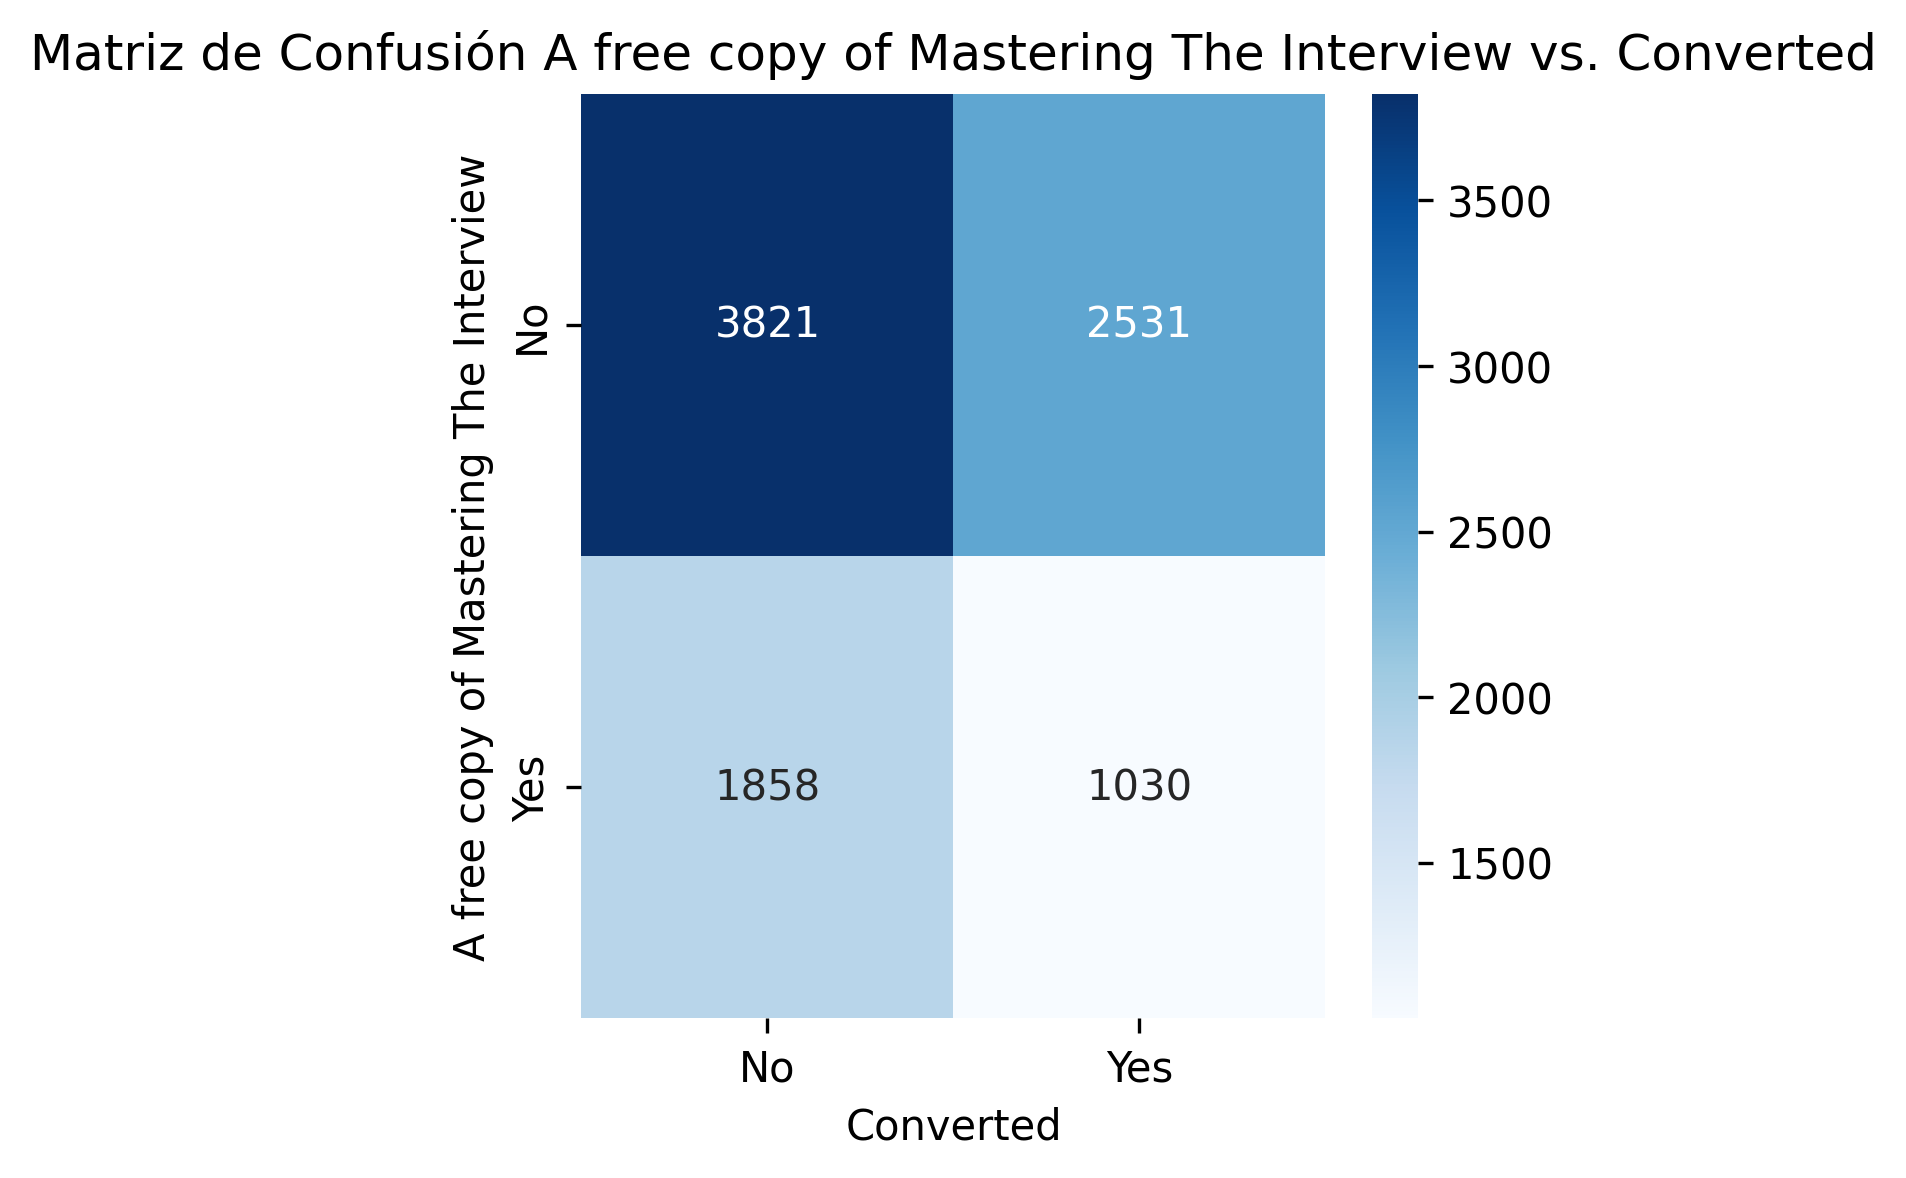

In [48]:
matriz_de_confusion('A free copy of Mastering The Interview')

Almost 1/3 of prospects wanted to receive a free copy of the book 31.3% = (1858+1030)/9240.

Interestingly, prospects who received a free copy of the book had a lower conversion rate (35.7% = 1030/(1858+1030) than those who did not (39.8% = 2531/(3821+2531)

Could this be because once prospects receive a copy of Mastering the Interview, they don't feel the need for the courses? Did they just give their details to get the free content?

# Exploratory Analysis of Numerical Variables

In [49]:
# Let's define the box and whisker plot function
def grafico_de_caja(independiente, dependiente='Converted'):
    plt.figure(figsize=(4,4), dpi =300)
    sns.boxplot(y=independiente, data=df, x = dependiente, hue = dependiente)
    plt.title("Gráficos de Caja de " + independiente + " por valores V/F de " + dependiente)
    plt.show()

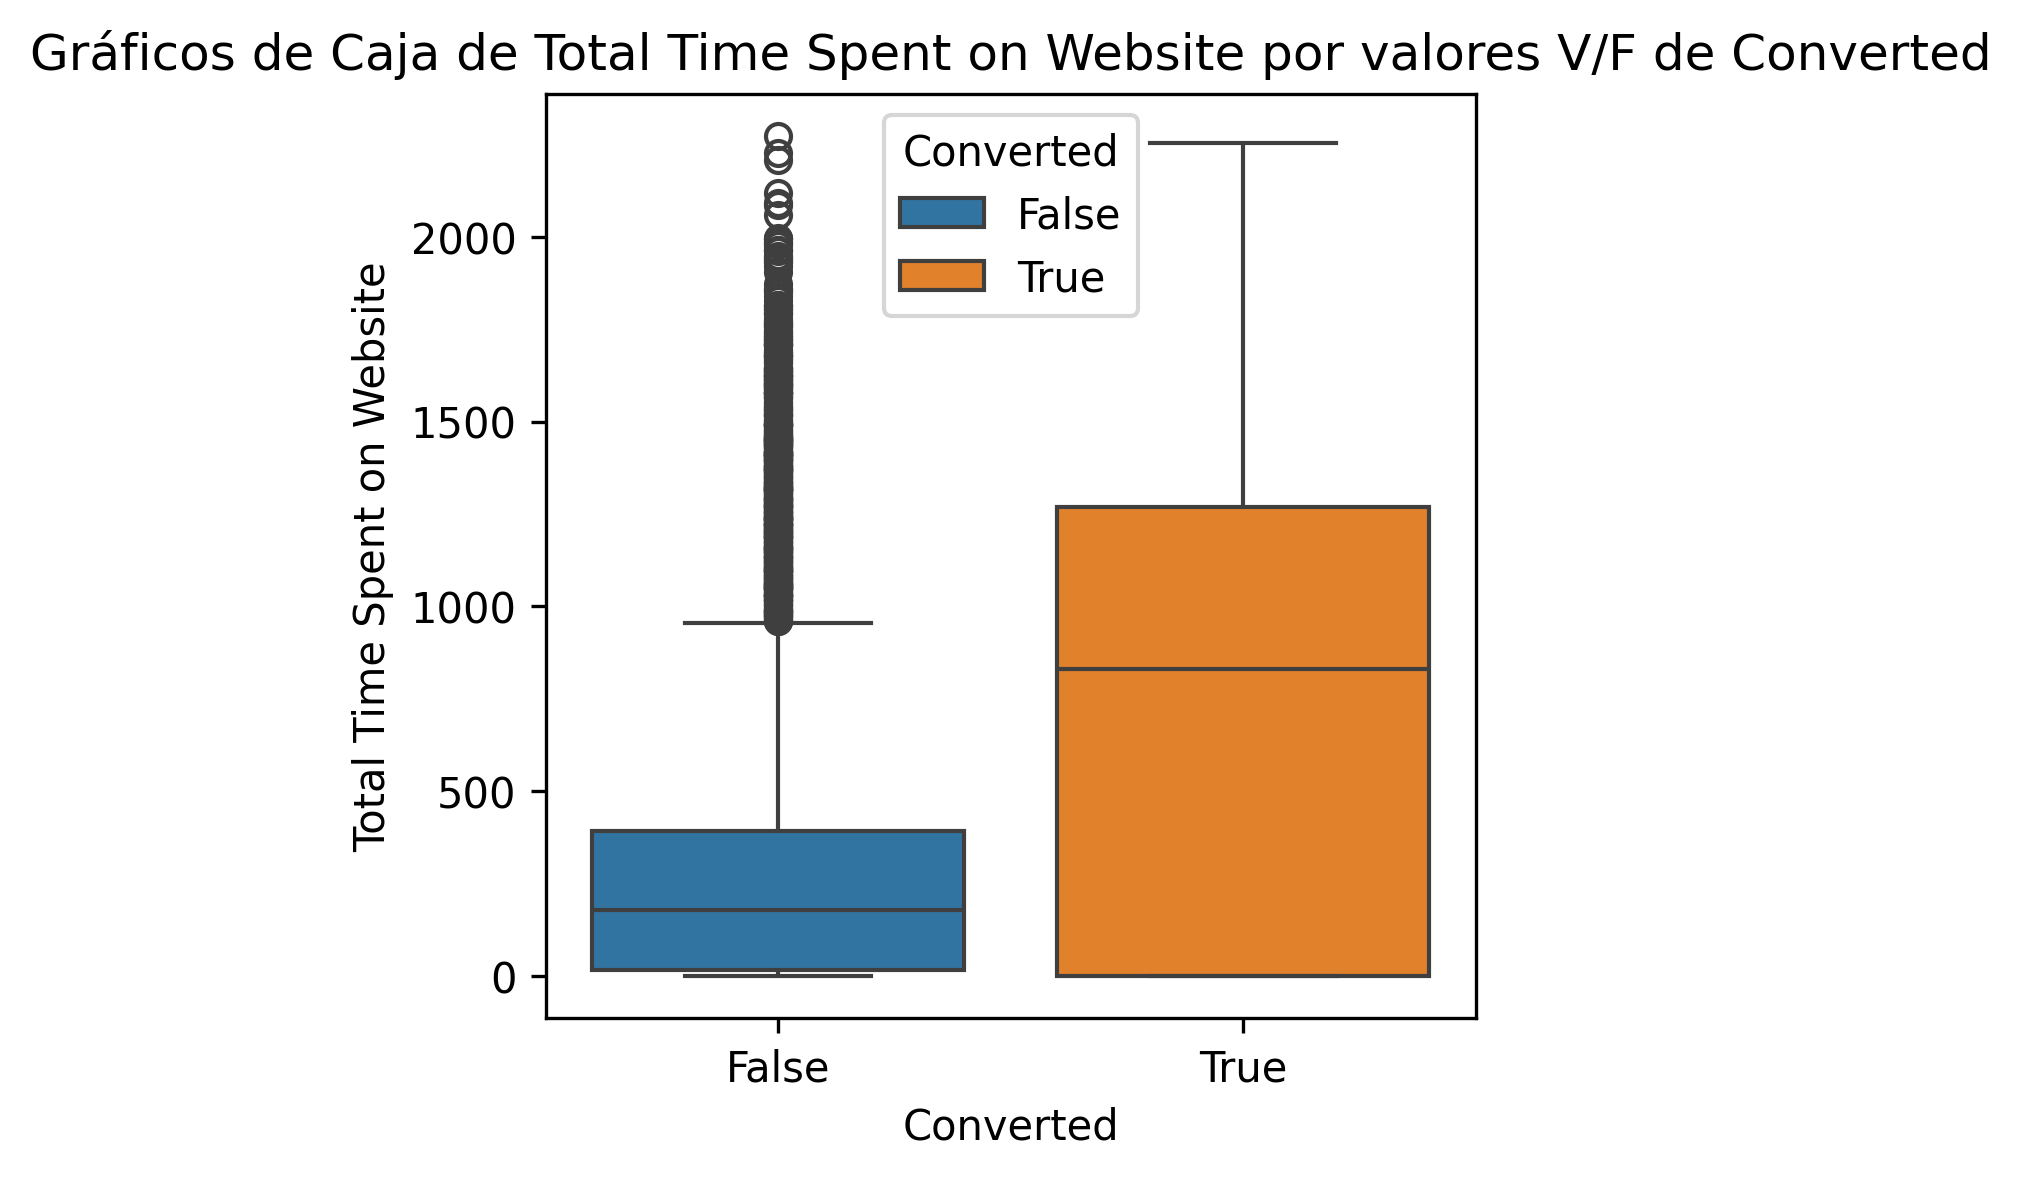

In [50]:
# Box Plot of 'Total Time Spent on Website'
grafico_de_caja('Total Time Spent on Website')

Insights:

The Interquartile Range (IQR) of Total Time Spent on Website for prospects who convert is much higher than for those who don't convert.

Encouraging prospects to spend more time on the website is likely to increase the overall conversion rate.

I could even focus on those leads who spent significant time on the website, but did not purchase. They may be interested and you should put more effort into closing the sale.

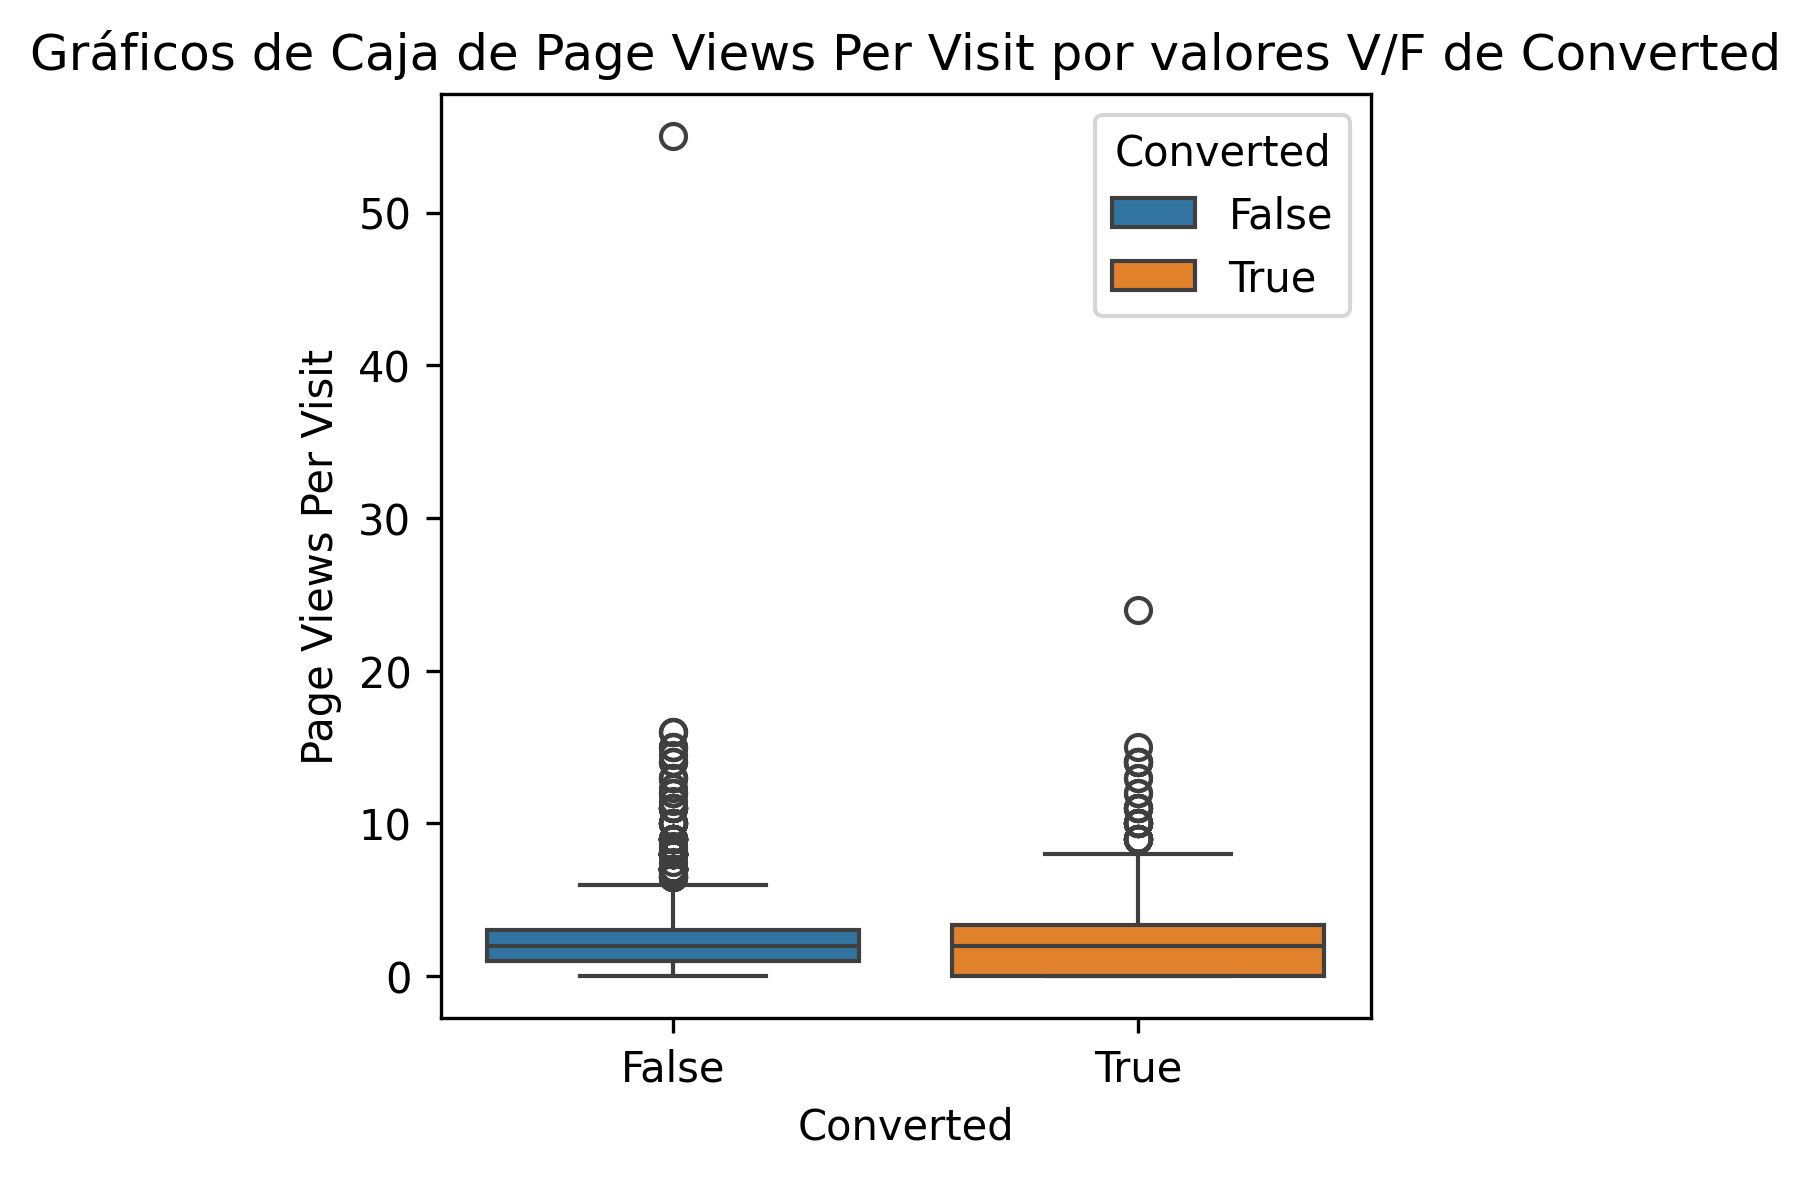

In [51]:
# Box Plot of 'Page Views Per Visit'

grafico_de_caja('Page Views Per Visit')

All leads appear to see a similar number of pages per visit on average, regardless of conversion status.

However, the Interquartile Range (IQR) of Page Views Per Visit is higher for leads that convert, in part because a large portion of leads that convert average 0 page views per visit.

The outlier who viewed 55 pages per visit on average might not be a sales opportunity, but in fact a competitor or a staff member viewing the website.

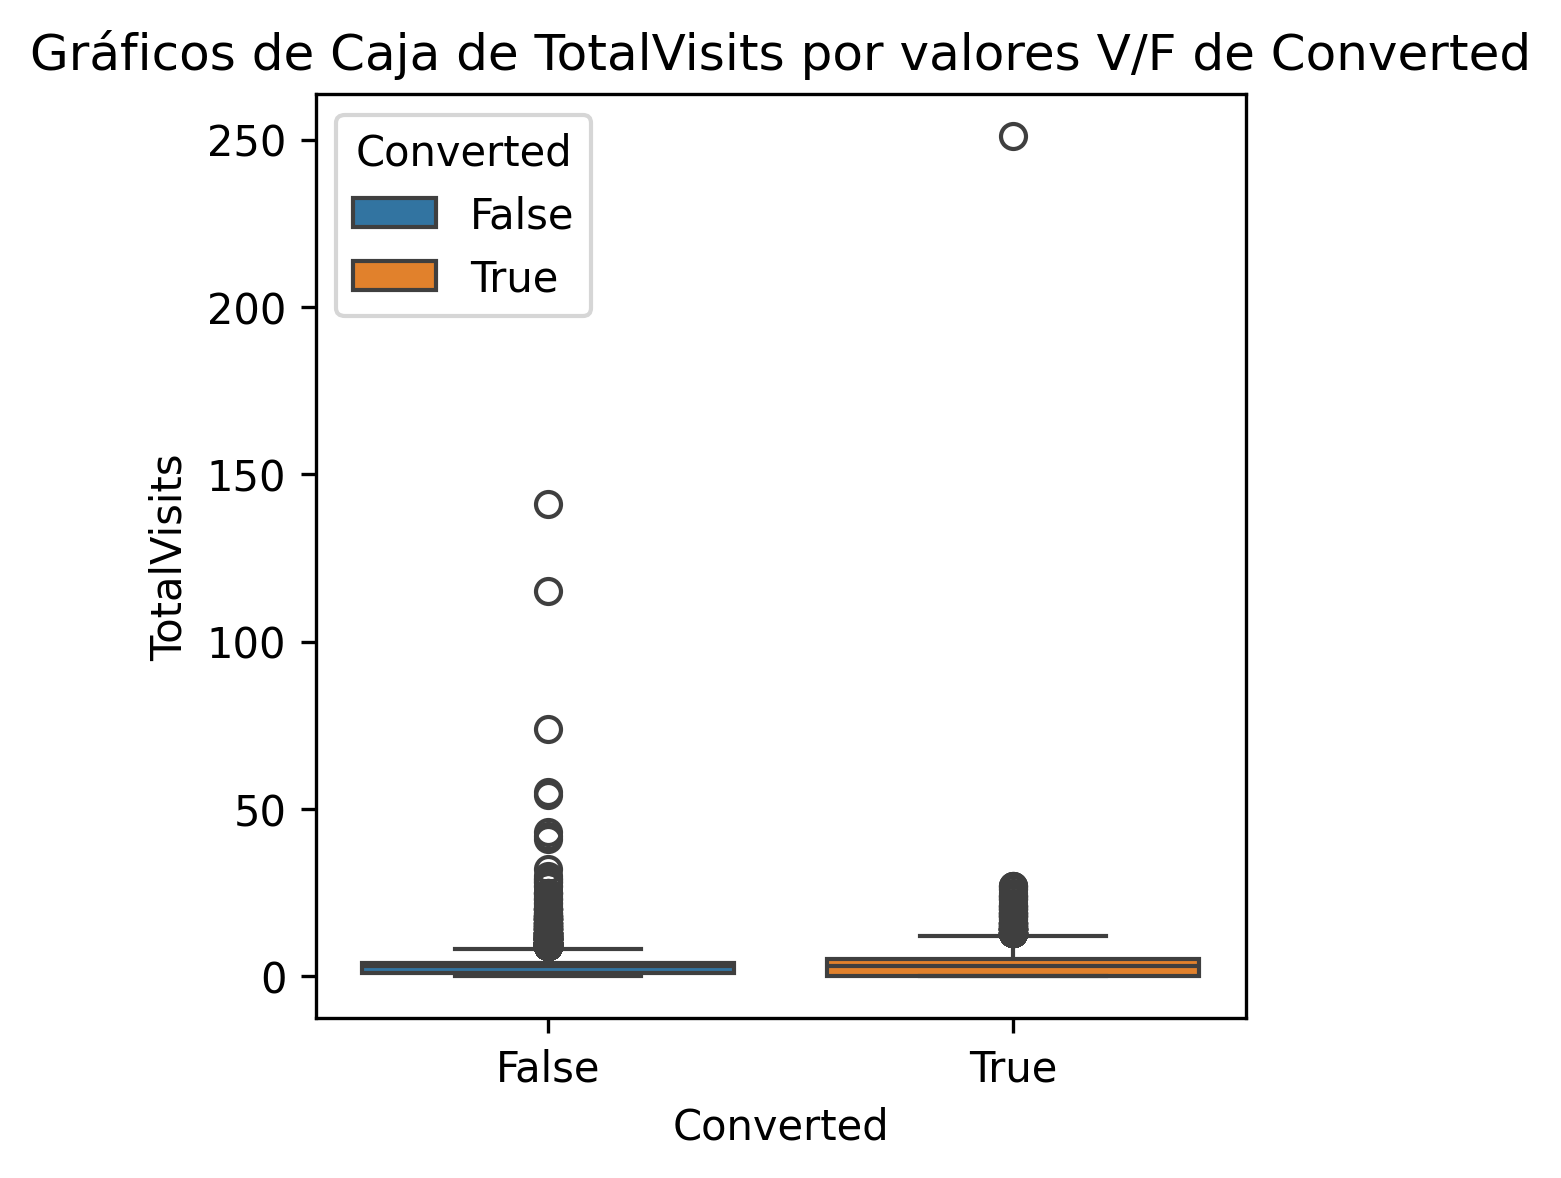

In [52]:
# Boxplot of 'TotalVisits'
grafico_de_caja('TotalVisits')

<Axes: xlabel='Converted', ylabel='TotalVisits'>

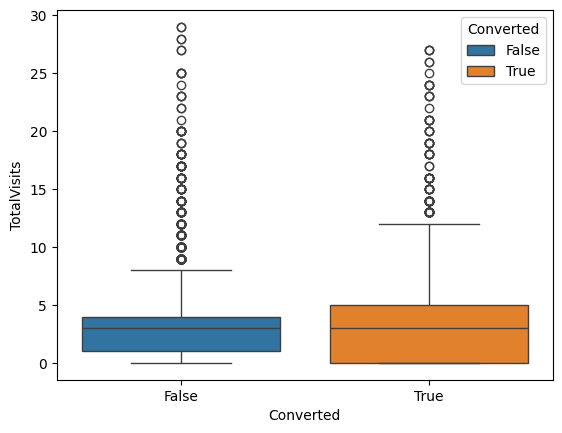

In [53]:
# It is not possible to interpret it due to the dispersion of the outliers. 
# Let's remove leads with more than 30 visits to the website
sns.boxplot(y='TotalVisits', data = df[df['TotalVisits']<30], x = 'Converted', hue = 'Converted')

In addition to visiting the website more frequently, sales leads that convert appear to show greater dispersion and Interquartile Range (IQR) than leads that do not convert.

# Development of the Logistic Regression Model

We identify the predictors of the model (all df variables with the exception of 'Converted' which is the dependent variable). We will also generate dummy variables from the categorical variables.

In [54]:
# We discard the dependent variable and generate the categorical dummies
X = pd.get_dummies(df.drop(columns='Converted', axis=1))
X.head()

Do Not Email  Do Not Call  TotalVisits  \
Lead Number                                           
660737              False        False          0.0   
660728              False        False          5.0   
660727              False        False          2.0   
660719              False        False          1.0   
660681              False        False          2.0   

             Total Time Spent on Website  Page Views Per Visit  Search  \
Lead Number                                                              
660737                                 0                   0.0   False   
660728                               674                   2.5   False   
660727                              1532                   2.0   False   
660719                               305                   1.0   False   
660681                              1428                   1.0   False   

             Magazine  Newspaper Article  X Education Forums  Newspaper  ...  \
Lead Number                                                              ...   
660737          False              False               False      False  ...   
660728          False              False               False      False  ...   
660727          False              False               False      False  ...   
660719          False              False               False      False  ...   
660681          False              False               False      False  ...   

             Last Notable Activity_Form Submitted on Website  \
Lead Number                                                    
660737                                                 False   
660728                                                 False   
660727                                                 False   
660719                                                 False   
660681                                                 False   

             Last Notable Activity_Had a Phone Conversation  \
Lead Number                                                   
660737                                                False   
660728                                                False   
660727                                                False   
660719                                                False   
660681                                                False   

             Last Notable Activity_Modified  \
Lead Number                                   
660737                                 True   
660728                                False   
660727                                False   
660719                                 True   
660681                                 True   

             Last Notable Activity_Olark Chat Conversation  \
Lead Number                                                  
660737                                               False   
660728                                               False   
660727                                               False   
660719                                               False   
660681                                               False   

             Last Notable Activity_Page Visited on Website  \
Lead Number                                                  
660737                                               False   
660728                                               False   
660727                                               False   
660719                                               False   
660681                                               False   

             Last Notable Activity_Resubscribed to emails  \
Lead Number                                                 
660737                                              False   
660728                                              False   
660727                                              False   
660719                                              False   
660681                                              False   

             Last Notable Ac

In [55]:
Y = df['Converted']

Then, we split our data into a training set and a test set (80% of the data will be used for the training set, while the remaining 20% ​​will be used in the test set).

In [56]:
X_entrenamiento, X_evaluacion, Y_entrenamiento, Y_evaluacion = train_test_split(X, Y, test_size = 0.2,
                                                                               random_state = 99, stratify = Y)

The parameter stratify = Y in train_test_split ensures that the proportion of classes in the training and testing sets is the same as the proportion of classes in the original data set Y.

In [57]:
# Scaling variables using MixMaxScaler
var_escalar = ['TotalVisits', 'Total Time Spent on Website','Page Views Per Visit']
escalar = MinMaxScaler()

X_entrenamiento[var_escalar] = escalar.fit_transform(X_entrenamiento[var_escalar])
X_entrenamiento.head()

Do Not Email  Do Not Call  TotalVisits  \
Lead Number                                           
627877              False        False     0.015936   
585642              False        False     0.015936   
617566              False        False     0.023904   
655639              False        False     0.015936   
593227              False        False     0.003984   

             Total Time Spent on Website  Page Views Per Visit  Search  \
Lead Number                                                              
627877                          0.672975              0.072727   False   
585642                          0.079225              0.036364   False   
617566                          0.453345              0.054545   False   
655639                          0.001320              0.072727   False   
593227                          0.210387              0.018182   False   

             Magazine  Newspaper Article  X Education Forums  Newspaper  ...  \
Lead Number                                                              ...   
627877          False              False               False      False  ...   
585642          False              False               False      False  ...   
617566          False              False               False      False  ...   
655639          False              False               False      False  ...   
593227          False              False               False      False  ...   

             Last Notable Activity_Form Submitted on Website  \
Lead Number                                                    
627877                                                 False   
585642                                                 False   
617566                                                 False   
655639                                                 False   
593227                                                 False   

             Last Notable Activity_Had a Phone Conversation  \
Lead Number                                                   
627877                                                False   
585642                                                False   
617566                                                False   
655639                                                False   
593227                                                False   

             Last Notable Activity_Modified  \
Lead Number                                   
627877                                False   
585642                                 True   
617566                                 True   
655639                                False   
593227                                 True   

             Last Notable Activity_Olark Chat Conversation  \
Lead Number                                                  
627877                                               False   
585642                                               False   
617566                                               False   
655639                                               False   
593227                                               False   

             Last Notable Activity_Page Visited on Website  \
Lead Number                                                  
627877                                               False   
585642                                               False   
617566                                               False   
655639                                               False   
593227                                               False   

             Last Notable Activity_Resubscribed to emails  \
Lead Number                                                 
627877                                              False   
585642                                              False   
617566                                              False   
655639                                              False   
593227                                              False   

             Last Notable Ac

And now the evaluation basis:
In data scaling, we use fit_transform on the training set to calculate the scaling parameters (such as minimum and maximum) and then apply the transformation. Instead, for the evaluation set, we only use transform to apply the same parameters already calculated, thus ensuring consistency and avoiding bias in our model.

In [58]:
X_evaluacion[var_escalar] = escalar.transform(X_evaluacion[var_escalar])
X_evaluacion.head()

Do Not Email  Do Not Call  TotalVisits  \
Lead Number                                           
591899              False        False     0.015936   
604007              False        False     0.019920   
653773              False        False     0.011952   
611519              False        False     0.015936   
584568              False        False     0.007968   

             Total Time Spent on Website  Page Views Per Visit  Search  \
Lead Number                                                              
591899                          0.173856              0.024182   False   
604007                          0.412852              0.090909   False   
653773                          0.111356              0.054545   False   
611519                          0.699384              0.072727   False   
584568                          0.014525              0.036364   False   

             Magazine  Newspaper Article  X Education Forums  Newspaper  ...  \
Lead Number                                                              ...   
591899          False              False               False      False  ...   
604007          False              False               False      False  ...   
653773          False              False               False      False  ...   
611519          False              False               False      False  ...   
584568          False              False               False      False  ...   

             Last Notable Activity_Form Submitted on Website  \
Lead Number                                                    
591899                                                 False   
604007                                                 False   
653773                                                 False   
611519                                                 False   
584568                                                 False   

             Last Notable Activity_Had a Phone Conversation  \
Lead Number                                                   
591899                                                False   
604007                                                False   
653773                                                False   
611519                                                False   
584568                                                False   

             Last Notable Activity_Modified  \
Lead Number                                   
591899                                False   
604007                                False   
653773                                False   
611519                                 True   
584568                                False   

             Last Notable Activity_Olark Chat Conversation  \
Lead Number                                                  
591899                                               False   
604007                                               False   
653773                                               False   
611519                                               False   
584568                                               False   

             Last Notable Activity_Page Visited on Website  \
Lead Number                                                  
591899                                               False   
604007                                               False   
653773                                               False   
611519                                               False   
584568                                               False   

             Last Notable Activity_Resubscribed to emails  \
Lead Number                                                 
591899                                              False   
604007                                              False   
653773                                              False   
611519                                              False   
584568                                              False   

             Last Notable Ac

Scaling data with MinMaxScaler after splitting the set into training and testing, rather than before, is a best practice to avoid data leakage. When you scale data before splitting, the scaling process takes into account the entire distribution of the data, including those in the evaluation set, which can lead to an unrealistically optimistic assessment of model performance. By scaling after splitting, you ensure that the scaling process is only based on the training data, thus maintaining the validity of the evaluation on the test set, which simulates unseen data.








In [59]:
# Create the logistic regression model

modelo_rl = LogisticRegression()
modelo_rl.fit(X_entrenamiento, Y_entrenamiento)

LogisticRegression()

In [60]:
# Predict the probabilities on the evaluation set

Y_prediccion = modelo_rl.predict_proba(X_evaluacion)[:, 1]
Y_prediccion

array([0.40144738, 0.9065351 , 0.06686649, ..., 0.14830148, 0.98096891,
       0.05108272])

# AUC y ROC

In [61]:
# Calculate the area under the curve (AUC)
# Let's estimate fpr and tpr from the roc_curve function
fpr, tpr, puntos_de_corte= roc_curve(Y_evaluacion, Y_prediccion)

In [62]:
# Calculate the area under the curve (AUC)
auc_rl = auc(fpr, tpr)
auc_rl

0.9198010217202087

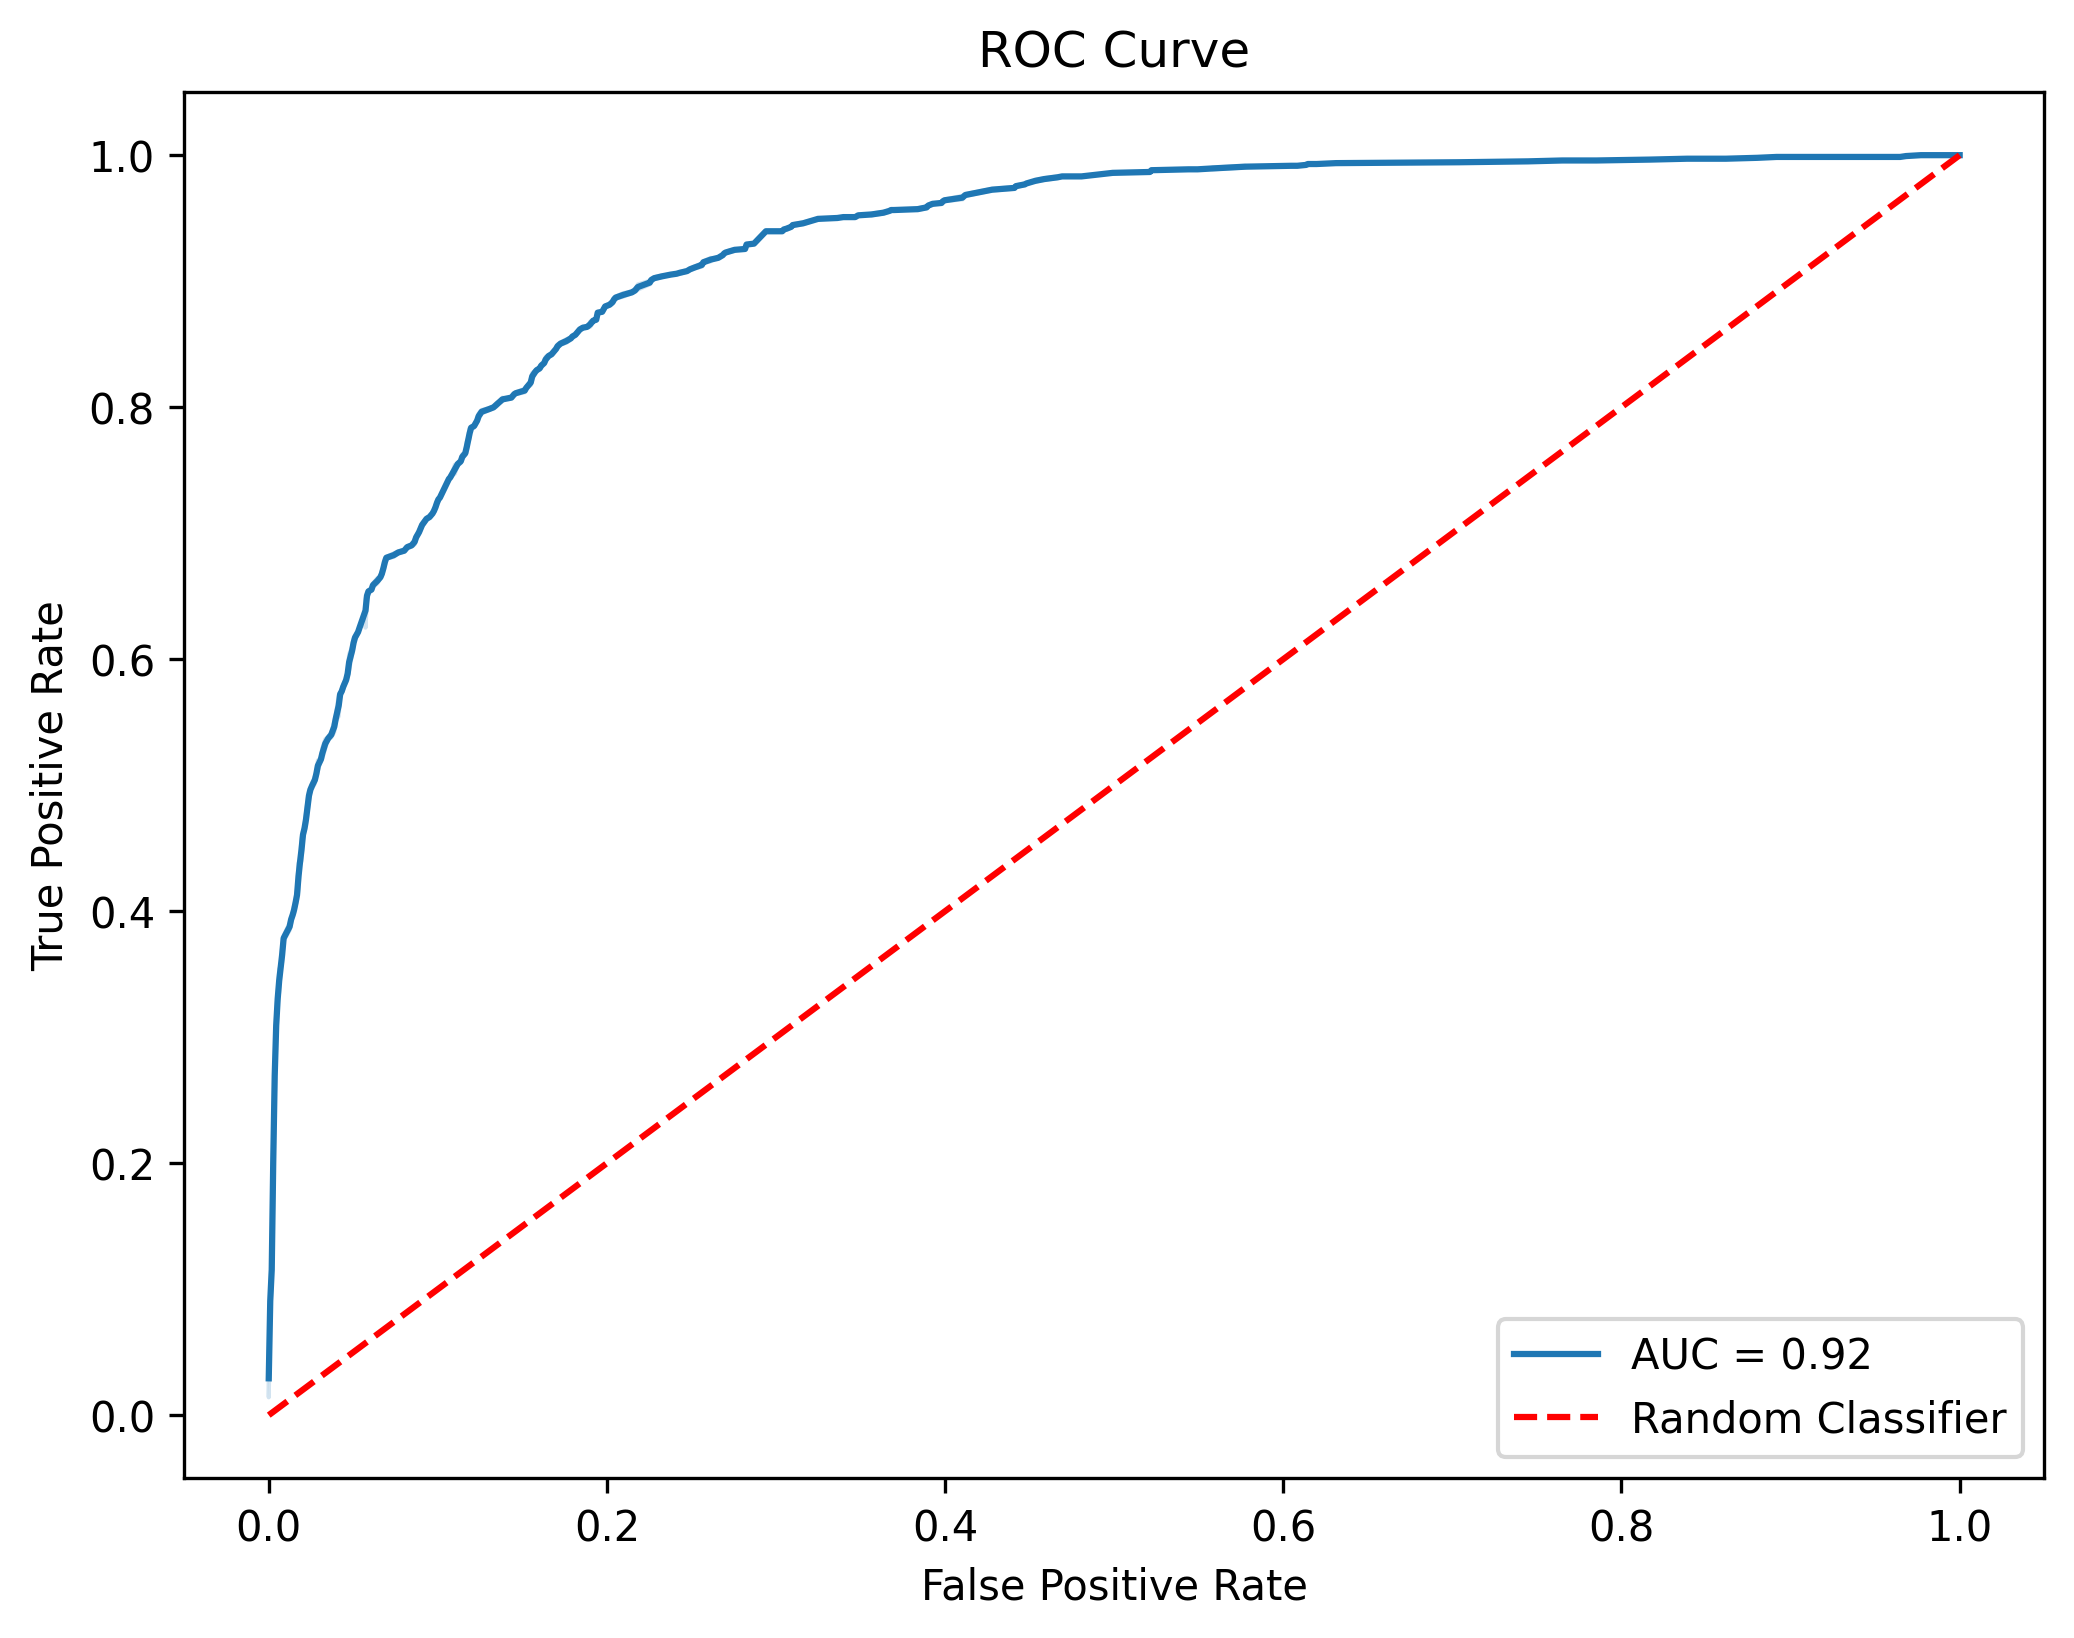

In [63]:
# Plot the ROC curve
plt.figure(figsize=(8, 6), dpi=300)
sns.lineplot(x=fpr, y=tpr, label='AUC = %0.2f' % auc_rl)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Based on the ROC curve obtained with an AUC of 0.92, we can conclude that the classification model has shown very good performance. An AUC of 0.92 means that there is a high probability that the model correctly classifies a positive random observation over a negative one.

# Prediction by Decision tree

In [64]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import roc_curve, auc

In [65]:
df = pd.read_csv('EON_preprocesado.csv', index_col = 'Lead Number')

In [66]:
# Coding for categorical variables (we transform them into dummies)
df = pd.get_dummies(df, drop_first = True)

# Division between characteristics (independent) and target variable (dependent)
X = df.drop('Converted', axis = 1)
Y = df['Converted']

# Balance classes
conteo_clases = df['Converted'].value_counts()
conteo_clases

Converted
False    5679
True     3561
Name: count, dtype: int64

In [67]:
porcentajes_clases = (conteo_clases / len(df['Converted'])) * 100
porcentajes_clases

Converted
False    61.461039
True     38.538961
Name: count, dtype: float64

Although the imbalance is not extreme, there is a significant difference between the classes: approximately 61% of the records belong to the False class and 39% to the True class.

In [68]:
# Apply SMOTE to balance classes
smote = SMOTE()
X_equilibrado, Y_equilibrado = smote.fit_resample(X,Y)
conteo_clases = Y_equilibrado.value_counts()
conteo_clases

Converted
False    5679
True     5679
Name: count, dtype: int64

In [69]:
# Split the data into training and test sets
X_entrenamiento, X_evaluacion, Y_entrenamiento, Y_evaluacion = train_test_split(X_equilibrado, Y_equilibrado,
                                                                               test_size = 0.2, random_state = 99)

scaler = MinMaxScaler()
X_entrenamiento = scaler.fit_transform(X_entrenamiento)
X_evaluacion = scaler.transform(X_evaluacion)

# Creating and Viewing the Classification Tree with best Hyperparameters and Search Grids

In [70]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Define the decision tree base model
modelo_arbol = DecisionTreeClassifier(random_state=99)

# Set parameters for grid search
parametros_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25],
    'min_samples_leaf': [10, 50, 100, 200, 500],
    'ccp_alpha': [0.0, 0.001, 0.002, 0.005, 0.010, 0.1]
}

# Create our object GridSearchCV
grid_search = GridSearchCV(modelo_arbol, parametros_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Run grid search on training data
grid_search.fit(X_entrenamiento, Y_entrenamiento)

# Best parameters found
mejores_parametros = grid_search.best_params_

# Best model found
mejor_modelo = grid_search.best_estimator_

# Code to print the results
print("Mejores parámetros encontrados:", mejores_parametros)
print("Mejor modelo:", mejor_modelo)

Mejores parámetros encontrados: {'ccp_alpha': 0.0, 'max_depth': 10, 'min_samples_leaf': 10}
Mejor modelo: DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=99)


In [71]:
from sklearn.metrics import roc_auc_score

# Assign the best parameters to the model
modelo_optimizado = DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, ccp_alpha=0.0, random_state=99)

# Train the model with the training data
modelo_optimizado.fit(X_entrenamiento, Y_entrenamiento)

# Make predictions on the evaluation set
Y_prediccion = modelo_optimizado.predict_proba(X_evaluacion)[:, 1]

# Calculate AUC using evaluation data
auc_optimizado = roc_auc_score(Y_evaluacion, Y_prediccion)

print("AUC del modelo optimizado:", auc_optimizado)

AUC del modelo optimizado: 0.9314638084425253


# Model Optimization with Grid Search with Hyperparameters

In [72]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# Decision Tree Model Configuration
decision_tree = DecisionTreeClassifier(random_state=99)

# Defining hyperparameters for grid search
parametros = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25],
    'min_samples_leaf': [10, 50, 100, 200, 500],
    'ccp_alpha': [0.0, 0.001, 0.002, 0.005, 0.010, 0.1]
}

# Grid search with cross validation
busqueda_cuadricula = GridSearchCV(decision_tree, parametros, cv=5, scoring='roc_auc')
busqueda_cuadricula.fit(X_entrenamiento, Y_entrenamiento)

# Best parameters and model
mejores_parametros = busqueda_cuadricula.best_params_
mejor_modelo = busqueda_cuadricula.best_estimator_

# Train and evaluate the best model
mejor_modelo.fit(X_entrenamiento, Y_entrenamiento)
predicciones = mejor_modelo.predict_proba(X_evaluacion)[:, 1]
auc = roc_auc_score(Y_evaluacion, predicciones)

mejores_parametros, auc

({'ccp_alpha': 0.0, 'max_depth': 10, 'min_samples_leaf': 10},
 0.9314638084425253)

In [73]:
plt.figure(figsize=(20,100), dpi = 300)
plot_tree(mejor_modelo,
         feature_names = X.columns.tolist(),
         class_names = ['No compró', 'Compró'],
         filled = True, impurity = False, rounded = True, fontsize = 10)
plt.show()

In this project, it was carried out from cleaning, data processing, analysis such as the use of logistic regression and decision tree with the use of grid search cv to know which of the hyperparameters with which we played was the best option to obtain the best results

-Daniel Pulido